In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 3

# Preparing coarsegrained data

In [3]:
#R64 = xr.open_mfdataset('~/experiments/Feb2022/bare/R64/output/prog*', decode_times=False, chunks={'Time':1})

In [58]:
static_R16 = xr.open_dataset('~/experiments/Feb2022/bare/R16/output/ocean_geometry.nc').rename(
    {'lath': 'yh', 'latq':'yq', 'lonh':'xh', 'lonq':'xq'})
static_R8 = xr.open_dataset('~/experiments/Feb2022/bare/R8/output/ocean_geometry.nc').rename(
    {'lath': 'yh', 'latq':'yq', 'lonh':'xh', 'lonq':'xq'})
static_R4 = xr.open_dataset('~/experiments/Feb2022/bare/R4/output/ocean_geometry.nc').rename(
    {'lath': 'yh', 'latq':'yq', 'lonh':'xh', 'lonq':'xq'})
static_R2 = xr.open_dataset('~/experiments/Feb2022/bare/R2/output/ocean_geometry.nc').rename(
    {'lath': 'yh', 'latq':'yq', 'lonh':'xh', 'lonq':'xq'})

In [21]:
from helpers.computational_tools import remesh
from dask.diagnostics import ProgressBar

In [59]:
ds = xr.Dataset()
ds['u'] = remesh(R64.u, static_R16.dxCu)
ds['v'] = remesh(R64.v, static_R16.dxCv)
with ProgressBar():
    ds.to_netcdf('a-priori/R64_R16.nc')

[########################################] | 100% Completed | 8.45 sms


In [23]:
ds = xr.Dataset()
ds['u'] = remesh(R64.u, static_R8.dxCu)
ds['v'] = remesh(R64.v, static_R8.dxCv)
with ProgressBar():
    ds.to_netcdf('a-priori/R64_R8.nc')

[########################################] | 100% Completed | 63.54 ss


In [24]:
ds = xr.Dataset()
ds['u'] = remesh(R64.u, static_R4.dxCu)
ds['v'] = remesh(R64.v, static_R4.dxCv)
with ProgressBar():
    ds.to_netcdf('a-priori/R64_R4.nc')

[########################################] | 100% Completed | 7.21 sms


In [25]:
ds = xr.Dataset()
ds['u'] = remesh(R64.u, static_R2.dxCu)
ds['v'] = remesh(R64.v, static_R2.dxCv)
with ProgressBar():
    ds.to_netcdf('a-priori/R64_R2.nc')

[########################################] | 100% Completed | 7.16 sms


In [71]:
static_R2.to_netcdf('a-priori/static_R2.nc')
static_R4.to_netcdf('a-priori/static_R4.nc')
static_R8.to_netcdf('a-priori/static_R8.nc')
static_R16.to_netcdf('a-priori/static_R16.nc')

# Dynamic model code

In [3]:
def read_data(RR='R4', chunk=50):
    prog = xr.open_dataset(f'a-priori/R64_{RR}.nc', decode_times=False, chunks={'Time':chunk})
    static = xr.open_dataset(f'a-priori/static_{RR}.nc', decode_times=False, chunks={'Time':1})
    return prog, static

In [3]:
prog, static = read_data('R8')

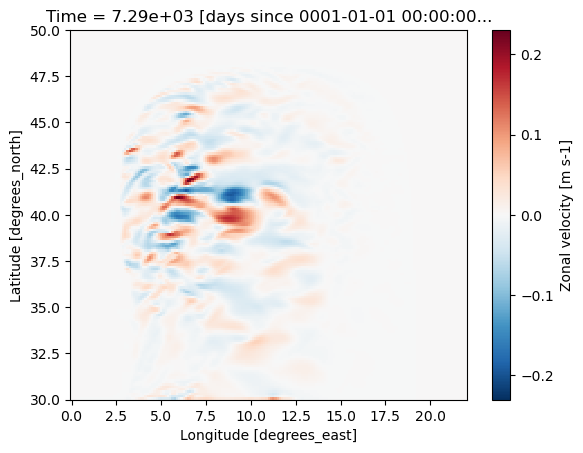

In [4]:
prog.u.isel(Time=-1,zl=1).plot()

In [7]:
import xgcm
    
def filter_iteration(u, mask=None, x='xq', y='yh', niter=1, filter_width=np.sqrt(6)):
    weight_side = filter_width**2 / 24.
    weight_center = 1. - 2. * weight_side 
    def weighted_sum(x, axis):
        weight = np.array([[weight_side, weight_center, weight_side]]).T @ np.array([[weight_side, weight_center, weight_side]])
        return (x * weight).sum([-1,-2])

    uf = u
    if mask is not None:
        uf = uf * mask
    for i in range(niter):
        uf = uf.pad({x:1,y:1}, constant_values=0).rolling({x:3, y:3}, center=True).reduce(weighted_sum).fillna(0.).isel({x:slice(1,-1),y:slice(1,-1)})
        if mask is not None:
            uf = uf * mask
    return uf.chunk({y:-1,x:-1})

def compute_velocity_gradients(u, v, static, grid):
    dudx = grid.diff(u * static.wet_u / static.dyCu, 'X') * static.dyT / static.dxT
    dvdy = grid.diff(v * static.wet_v / static.dxCv, 'Y') * static.dxT / static.dyT
    
    dudy = (grid.diff(u * static.wet_u / static.dxCu, 'Y') * static.dxBu / static.dyBu * static.wet_c)
    dvdx = (grid.diff(v * static.wet_v / static.dyCv, 'X') * static.dyBu / static.dxBu * static.wet_c)

    sh_xx = (dudx-dvdy) * static.wet
    sh_xy = (dvdx+dudy) * static.wet_c
    shear_mag = np.sqrt(sh_xy**2 + grid.interp(sh_xx**2,['X','Y'])) * static.wet_c

    vort_xy = (grid.diff(v * static.wet_v * static.dyCv, 'X') - grid.diff(u * static.wet_u * static.dxCu, 'Y')) * static.wet_c / (static.dxBu * static.dyBu)

    return sh_xx, sh_xy, shear_mag, vort_xy

def compute_vorticity_gradients(vort_xy, static, grid):
    vort_x = static.wet_v/static.dxCv * grid.diff(vort_xy,'X')
    vort_y = static.wet_u/static.dyCu * grid.diff(vort_xy,'Y')
    lap_vort = (grid.diff(vort_x * static.dyCv,'X') + grid.diff(vort_y * static.dxCu, 'Y')) * static.wet_c / (static.dxBu * static.dyBu)
    lap_vort_x = static.wet_v/static.dxCv * grid.diff(lap_vort,'X')
    lap_vort_y = static.wet_u/static.dyCu * grid.diff(lap_vort,'Y')
    return vort_x, vort_y, lap_vort, lap_vort_x, lap_vort_y

def divergence_momentum_flux(Txx, Txy, Tyy, static, grid):
        IdxCu = 1. / static.dxCu
        IdyCu = 1. / static.dyCu
        IdxCv = 1. / static.dxCv
        IdyCv = 1. / static.dyCv
        
        IareaCu = 1. / (static.dxCu * static.dyCu)
        IareaCv = 1. / (static.dxCv * static.dyCv)
        dx2q = static.dxBu**2
        dy2q = static.dyBu**2
        dx2h = static.dxT**2
        dy2h = static.dyT**2

        fx = (
                IdyCu * grid.diff(dy2h*Txx,'X') +
                IdxCu * grid.diff(dx2q*Txy,'Y')
        ) * IareaCu
        
        fy = (
                IdyCv * grid.diff(dy2q*Txy,'X') + 
                IdxCv * grid.diff(dx2h*Tyy,'Y')
        ) * IareaCv

        return fx,fy

def dyn_model(prog, static, tf_width=np.sqrt(6), tf_iter=1, filters_ratio=np.sqrt(2), ssm=False, reynolds=False, compute=lambda x: x.compute()):
    if ssm and tf_iter>1:
        print('Not Implemented error')
        return
    
    grid = xgcm.Grid(static, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}},
            boundary={'X': 'fill', 'Y': 'fill'},
            fill_value = {'X': 0, 'Y': 0})
    static['wet_u']=np.floor(grid.interp(static.wet,'X'))
    static['wet_v']=np.floor(grid.interp(static.wet,'Y'))
    static['wet_c']=np.floor(grid.interp(static.wet,['X','Y']))

    dx2q = static.dxBu**2 ; dy2q = static.dyBu**2
    grid_sp_q4 = ((2.0*dx2q*dy2q) / (dx2q+dy2q))**2

    u = (prog.u * static.wet_u).fillna(0.).astype('float64')
    v = (prog.v * static.wet_v).fillna(0.).astype('float64')
    
    # Model in vorticity fluxes
    uf = filter_iteration(u, static.wet_u, 'xq', 'yh', tf_iter, tf_width)
    vf = filter_iteration(v, static.wet_v, 'xh', 'yq', tf_iter, tf_width)

    sh_xx, sh_xy, shear_mag, vort_xy = compute_velocity_gradients(u, v, static, grid)
    sh_xxf, sh_xyf, shear_magf, vort_xyf = compute_velocity_gradients(uf, vf, static, grid)

    vort_x, vort_y, lap_vort, lap_vort_x, lap_vort_y = compute_vorticity_gradients(vort_xy, static, grid)
    vort_xf, vort_yf, lap_vortf, lap_vort_xf, lap_vort_yf = compute_vorticity_gradients(vort_xyf, static, grid)

    smag_x = lap_vort_x * grid.interp(shear_mag * grid_sp_q4,'X')
    smag_y = lap_vort_y * grid.interp(shear_mag * grid_sp_q4,'Y')

    smag_x = filter_iteration(smag_x, static.wet_v, 'xh', 'yq', tf_iter, tf_width)
    smag_y = filter_iteration(smag_y, static.wet_u, 'xq', 'yh', tf_iter, tf_width)

    smag_xf = (filters_ratio)**4 * lap_vort_xf * grid.interp(shear_magf * grid_sp_q4,'X')
    smag_yf = (filters_ratio)**4 * lap_vort_yf * grid.interp(shear_magf * grid_sp_q4,'Y')

    m_x = smag_xf - smag_x
    m_y = smag_yf - smag_y

    leo_x = filter_iteration(grid.interp(u,['X','Y']) * grid.interp(vort_xy,'X'), static.wet_v, 'xh', 'yq', tf_iter, tf_width) - \
            grid.interp(uf,['X','Y']) * grid.interp(vort_xyf,'X')
    leo_x = leo_x * static.wet_v
    
    leo_y = filter_iteration(grid.interp(v,['X','Y']) * grid.interp(vort_xy,'Y'), static.wet_u, 'xq','yh', tf_iter, tf_width) - \
            grid.interp(vf,['X','Y']) * grid.interp(vort_xyf,'Y')
    leo_y = leo_y * static.wet_u

    if ssm:
        h_x_comb = filter_iteration(grid.interp(uf,['X','Y']) * grid.interp(vort_xyf,'X'), static.wet_v, 'xh', 'yq', 2, tf_width) - \
                grid.interp(
                    filter_iteration(uf, static.wet_u, 'xq', 'yh', 2, tf_width),
                    ['X','Y']) * \
                grid.interp(
                    filter_iteration(vort_xyf, static.wet_c, 'xq', 'yq', 2, tf_width),
                            'X')
    
        h_y_comb = filter_iteration(grid.interp(vf,['X','Y']) * grid.interp(vort_xyf,'Y'), static.wet_u, 'xq', 'yh', 2, tf_width) - \
                grid.interp(
                    filter_iteration(vf, static.wet_v, 'xh', 'yq', 2, tf_width),
                    ['X','Y']) * \
                grid.interp(
                    filter_iteration(vort_xyf, static.wet_c, 'xq', 'yq', 2, tf_width),
                            'Y')
        h_x_basef = filter_iteration(leo_x, static.wet_v, 'xh', 'yq', 1, tf_width)
        h_y_basef = filter_iteration(leo_y, static.wet_u, 'xq', 'yh', 1, tf_width)
        h_x = h_x_comb - h_x_basef
        h_y = h_y_comb - h_y_basef
    else:
        h_x = 0
        h_y = 0
        h_x_comb = 0
        h_y_comb = 0
        h_x_basef = 0
        h_y_basef = 0

    if reynolds:
        ur = u - uf
        vr = v - vf
        vort_xyr = vort_xy - vort_xyf
        
        bx_base = filter_iteration(grid.interp(ur,['X','Y']) * grid.interp(vort_xyr,'X'), static.wet_v, 'xh', 'yq', 1, tf_width) - \
                grid.interp(
                    filter_iteration(ur, static.wet_u, 'xq', 'yh', 1, tf_width),
                    ['X','Y']) * \
                grid.interp(
                    filter_iteration(vort_xyr, static.wet_c, 'xq', 'yq', 1, tf_width),
                            'X')

        by_base = filter_iteration(grid.interp(vr,['X','Y']) * grid.interp(vort_xyr,'Y'), static.wet_u, 'xq', 'yh', 1, tf_width) - \
                grid.interp(
                    filter_iteration(vr, static.wet_v, 'xh', 'yq', 1, tf_width),
                    ['X','Y']) * \
                grid.interp(
                    filter_iteration(vort_xyr, static.wet_c, 'xq', 'yq', 1, tf_width),
                            'Y')

        ur = uf - filter_iteration(uf, static.wet_u, 'xq', 'yh', 2, tf_width)
        vr = vf - filter_iteration(vf, static.wet_v, 'xh', 'yq', 2, tf_width)
        vort_xyr = vort_xyf - filter_iteration(vort_xyf, static.wet_c, 'xq', 'yq', 2, tf_width)

        bx_comb = filter_iteration(grid.interp(ur,['X','Y']) * grid.interp(vort_xyr,'X'), static.wet_v, 'xh', 'yq', 2, tf_width) - \
                grid.interp(
                    filter_iteration(ur, static.wet_u, 'xq', 'yh', 2, tf_width),
                    ['X','Y']) * \
                grid.interp(
                    filter_iteration(vort_xyr, static.wet_c, 'xq', 'yq', 2, tf_width),
                            'X')

        by_comb = filter_iteration(grid.interp(vr,['X','Y']) * grid.interp(vort_xyr,'Y'), static.wet_u, 'xq', 'yh', 2, tf_width) - \
                grid.interp(
                    filter_iteration(vr, static.wet_v, 'xh', 'yq', 2, tf_width),
                    ['X','Y']) * \
                grid.interp(
                    filter_iteration(vort_xyr, static.wet_c, 'xq', 'yq', 2, tf_width),
                            'Y')

        bx = bx_comb - filter_iteration(bx_base, static.wet_v, 'xh', 'yq', 1, tf_width)
        by = by_comb - filter_iteration(by_base, static.wet_u, 'xq', 'yh', 1, tf_width)
    else:
        bx = 0 * leo_x
        by = 0 * leo_y
        bx_base = 0 * leo_x
        by_base = 0 * leo_y

    mm_vort_flux = (grid.interp(m_x**2, 'Y') + grid.interp(m_y**2,'X')) * static.dxT * static.dyT
    lm_vort_flux = (grid.interp((leo_x-h_x)*m_x,'Y') + grid.interp((leo_y-h_y)*m_y,'X')) * static.dxT * static.dyT

    Cs_vort_flux_sum = ((lm_vort_flux).sum(['xh', 'yh']) / (mm_vort_flux).sum(['xh', 'yh'])); 
    Cs_vort_flux_sum['Time'] = u.Time
    Cs_vort_flux_clip = ((np.maximum(lm_vort_flux,0.0)).sum(['xh', 'yh']) / (mm_vort_flux).sum(['xh', 'yh']))
    Cs_vort_flux_clip['Time'] = u.Time

    lb_vort_flux = (grid.interp((leo_x-h_x)*bx,'Y') + grid.interp((leo_y-h_y)*by,'X')) * static.dxT * static.dyT
    mb_vort_flux = (grid.interp(m_x*bx,'Y') + grid.interp(m_y*by,'X')) * static.dxT * static.dyT
    bb_vort_flux = (grid.interp(bx*bx,'Y') + grid.interp(by*by,'X')) * static.dxT * static.dyT

    CR_sum = (lb_vort_flux.sum(['xh', 'yh']) - Cs_vort_flux_sum * mb_vort_flux.sum(['xh', 'yh'])) / (bb_vort_flux.sum(['xh', 'yh']) + 1e-40)
    CR_clip = (lb_vort_flux.sum(['xh', 'yh']) - Cs_vort_flux_clip * mb_vort_flux.sum(['xh', 'yh'])) / (bb_vort_flux.sum(['xh', 'yh']) + 1e-40)

    # Model in divergence of vorticity fluxes
    _, _, lap2_vort, _, _ = compute_vorticity_gradients(lap_vort, static, grid)
    _, _, lap2_vortf, _, _ = compute_vorticity_gradients(lap_vortf, static, grid)
    smag = shear_mag * grid_sp_q4 * lap2_vort
    smag = filter_iteration(smag, static.wet_c, 'xq', 'yq', tf_iter, tf_width)
    smagf = (filters_ratio)**4 * shear_magf * grid_sp_q4 * lap2_vortf
    m = smagf - smag

    # Divergence of leonard vorticity flux
    leo = (grid.diff(leo_x * static.dyCv,'X') + grid.diff(leo_y * static.dxCu, 'Y')) * static.wet_c / (static.dxBu * static.dyBu)

    mm_vort_div = m * m
    lm_vort_div = leo * m

    Cs_vort_div_sum = ((lm_vort_div * static.dxBu * static.dyBu).sum(['xq', 'yq']) / (mm_vort_div * static.dxBu * static.dyBu).sum(['xq', 'yq'])); 
    Cs_vort_div_sum['Time'] = u.Time
    Cs_vort_div_clip = ((np.maximum(lm_vort_div, 0.0) * static.dxBu * static.dyBu).sum(['xq', 'yq']) / (mm_vort_div * static.dxBu * static.dyBu).sum(['xq', 'yq']))
    Cs_vort_div_clip['Time'] = u.Time 

    # Momentum flux
    Del2u, Del2v = divergence_momentum_flux(sh_xx, sh_xy, -sh_xx, static, grid)
    Del2uf, Del2vf = divergence_momentum_flux(sh_xxf, sh_xyf, -sh_xxf, static, grid)

    lap_sh_xx, lap_sh_xy, _, _ = compute_velocity_gradients(Del2u, Del2v, static, grid)
    lap_sh_xxf, lap_sh_xyf, _, _ = compute_velocity_gradients(Del2uf, Del2vf, static, grid)
    
    Txy = grid_sp_q4 * shear_mag * lap_sh_xy
    Txx = grid.interp(grid_sp_q4 * shear_mag, ['X', 'Y']) * lap_sh_xx
    Txy = filter_iteration(Txy, static.wet_c, 'xq', 'yq', tf_iter, tf_width)
    Txx = filter_iteration(Txx, static.wet, 'xh', 'yh', tf_iter, tf_width)

    Txyf = (filters_ratio)**4 * grid_sp_q4 * shear_magf * lap_sh_xyf
    Txxf = (filters_ratio)**4 * grid.interp(grid_sp_q4 * shear_magf, ['X', 'Y']) * lap_sh_xxf

    # Diagnostic output to compare definitions of Smagorinsky coefficient
    diag_x, diag_y = divergence_momentum_flux(lap_sh_xx, lap_sh_xy, -lap_sh_xx, static, grid)
    diag_lap2vort = (grid.diff(diag_y * static.wet_v * static.dyCv, 'X') - grid.diff(diag_x * static.wet_u * static.dxCu, 'Y')) * static.wet_c / (static.dxBu * static.dyBu)

    m_xx = Txxf - Txx
    m_xy = Txyf - Txy
    m_yy = -m_xx

    leo_xx = grid.interp(filter_iteration(u**2, static.wet_u, 'xq', 'yh', tf_iter, tf_width) - uf**2, 'X') * static.wet
    leo_yy = grid.interp(filter_iteration(v**2, static.wet_v, 'xh', 'yq', tf_iter, tf_width) - vf**2, 'Y') * static.wet
    leo_xy = filter_iteration(grid.interp(u,'Y') * grid.interp(v,'X'), static.wet_c, 'xq', 'yq', tf_iter, tf_width) - \
             grid.interp(uf,'Y') * grid.interp(vf,'X') * static.wet_c

    lm_mom_flux = leo_xx * m_xx + leo_yy * m_yy + grid.interp(leo_xy * m_xy * 2, ['X', 'Y']) * static.wet
    mm_mom_flux = m_xx * m_xx + m_yy * m_yy + grid.interp(m_xy * m_xy * 2, ['X', 'Y']) * static.wet

    Cs_mom_flux_sum = ((lm_mom_flux * static.dxT * static.dyT).sum(['xh', 'yh']) / (mm_mom_flux * static.dxT * static.dyT).sum(['xh', 'yh'])); 
    Cs_mom_flux_sum['Time'] = u.Time
    Cs_mom_flux_clip = ((np.maximum(lm_mom_flux, 0.) * static.dxT * static.dyT).sum(['xh', 'yh']) / (mm_mom_flux * static.dxT * static.dyT).sum(['xh', 'yh'])); 
    Cs_mom_flux_clip['Time'] = u.Time 
    
    

    return {'u':u, 'v': v, 'uf': uf, 'vf': vf,
            'sh_xx': sh_xx, 'sh_xy': sh_xy, 'shear_mag': shear_mag, 'vort_xy': vort_xy,
            'sh_xxf': sh_xxf, 'sh_xyf': sh_xyf, 'shear_magf': shear_magf, 'vort_xyf': vort_xyf,
            'vort_x': vort_x, 'vort_y': vort_y, 'lap_vort': lap_vort, 'lap_vort_x': lap_vort_x, 'lap_vort_y': lap_vort_y,
            'vort_xf': vort_xf, 'vort_yf': vort_yf, 'lap_vortf': lap_vortf, 'lap_vort_xf': lap_vort_xf, 'lap_vort_yf': lap_vort_yf,
            'smag_x': smag_x, 'smag_y': smag_y,
            'smag_xf': smag_xf, 'smag_yf': smag_yf,
            'Txxf': Txxf, 'Tyyf': Txxf,
            'smag': smag, 'smagf': smagf,
            'lap2_vort': lap2_vort, 'diag_lap2vort': diag_lap2vort,
            'm_x' : m_x, 'm_y': m_y,
            'leo_x': leo_x, 'leo_y': leo_y,
            'h_x': h_x, 'h_y': h_y,
            'h_x_comb': h_x_comb, 'h_y_comb': h_y_comb,
            'h_x_basef': h_x_basef, 'h_y_basef': h_y_basef,
            'bx': bx, 'by': by,
            'bx_base': bx_base, 'by_base': by_base,
            'm': m, 'leo': leo,
            'm_xx': m_xx, 'm_xy': m_xy, 'm_yy': m_yy, 
            'leo_xx': leo_xx, 'leo_xy': leo_xy, 'leo_yy': leo_yy,
            'lm_vort_flux': lm_vort_flux, 'mm_vort_flux': mm_vort_flux,
            'lb_vort_flux': lb_vort_flux, 'mb_vort_flux': mb_vort_flux,
            'bb_vort_flux': bb_vort_flux,
            'lm_vort_div': lm_vort_div, 'mm_vort_div': mm_vort_div,
            'lm_mom_flux': lm_mom_flux, 'mm_mom_flux': mm_mom_flux,
            'Cs_vort_flux_sum': compute(Cs_vort_flux_sum), 'Cs_vort_flux_clip': compute(Cs_vort_flux_clip),
            'Cs_vort_div_sum': compute(Cs_vort_div_sum), 'Cs_vort_div_clip': compute(Cs_vort_div_clip),
            'Cs_mom_flux_sum': compute(Cs_mom_flux_sum), 'Cs_mom_flux_clip': compute(Cs_mom_flux_clip),
            'CR_sum': compute(CR_sum), 'CR_clip': compute(CR_clip)
           }

In [49]:
def dyn_model_Chinese(prog, static, tf_width=np.sqrt(6), tf_iter=1, ssm=False, reynolds=False, compute=lambda x: x.compute()):
    '''
    Here for simplicity we implement only case when bar(Delta) = hat(Delta)
    and use
    Eq. (32) from https://link.springer.com/article/10.1186/s42774-022-00107-z
    In this case
    tau(u, bar(Delta)) = bar(uu) - bar(u)^2 = C_s Delta_g^4 * |bar(S)| bar(S_{ij}),
    also we have exactly same expression for test-filtered field with same C_s, because filters are equal:
    tau(u, hat(Delta)) = hat(uu) - hat(u)^2 = C_s Delta_g^4 * |hat(S)| hat(S_{ij}),

    Finally, we put here bar(u) instead of u:
    tau(bar(u),hat(Delta)) = hat(bar(u) bar(u)) - hat(u(bar(u))^2 = C_s Delta_g^4 * |hat(bar(S)) hat(bar(S_ij))
    '''
    if ssm and tf_iter > 1:
        print('Not implemented error')
        return
    grid = xgcm.Grid(static, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}},
            boundary={'X': 'fill', 'Y': 'fill'},
            fill_value = {'X': 0, 'Y': 0})
    static['wet_u']=np.floor(grid.interp(static.wet,'X'))
    static['wet_v']=np.floor(grid.interp(static.wet,'Y'))
    static['wet_c']=np.floor(grid.interp(static.wet,['X','Y']))

    dx2q = static.dxBu**2 ; dy2q = static.dyBu**2
    grid_sp_q4 = ((2.0*dx2q*dy2q) / (dx2q+dy2q))**2

    u = (prog.u * static.wet_u).fillna(0.).astype('float64')
    v = (prog.v * static.wet_v).fillna(0.).astype('float64')
    
    # Model in vorticity fluxes
    uf = filter_iteration(u, static.wet_u, 'xq', 'yh', tf_iter, tf_width)
    vf = filter_iteration(v, static.wet_v, 'xh', 'yq', tf_iter, tf_width)

    _, _, _, vort_xy = compute_velocity_gradients(u, v, static, grid)
    sh_xxf, sh_xyf, shear_magf, vort_xyf = compute_velocity_gradients(uf, vf, static, grid)

    vort_xf, vort_yf, lap_vortf, lap_vort_xf, lap_vort_yf = compute_vorticity_gradients(vort_xyf, static, grid)

    smag_xf = lap_vort_xf * grid.interp(shear_magf * grid_sp_q4,'X')
    smag_yf = lap_vort_yf * grid.interp(shear_magf * grid_sp_q4,'Y')

    m_x = smag_xf
    m_y = smag_yf

    leo_x = filter_iteration(grid.interp(u,['X','Y']) * grid.interp(vort_xy,'X'), static.wet_v, 'xh', 'yq', tf_iter, tf_width) - \
            grid.interp(uf,['X','Y']) * grid.interp(vort_xyf,'X')
    leo_x = leo_x * static.wet_v
    
    leo_y = filter_iteration(grid.interp(v,['X','Y']) * grid.interp(vort_xy,'Y'), static.wet_u, 'xq','yh', tf_iter, tf_width) - \
            grid.interp(vf,['X','Y']) * grid.interp(vort_xyf,'Y')
    leo_y = leo_y * static.wet_u

    if ssm:
        h_x = filter_iteration(grid.interp(uf,['X','Y']) * grid.interp(vort_xyf,'X'), static.wet_v, 'xh', 'yq', 1, tf_width) - \
              grid.interp(
                  filter_iteration(uf, static.wet_u, 'xq', 'yh', 1, tf_width),
                  ['X','Y']) * \
              grid.interp(
                  filter_iteration(vort_xyf, static.wet_c, 'xq', 'yq', 1, tf_width),
                  'X')
        h_y = filter_iteration(grid.interp(vf,['X','Y']) * grid.interp(vort_xyf,'Y'), static.wet_u, 'xq', 'yh', 1, tf_width) - \
              grid.interp(
                  filter_iteration(vf, static.wet_v, 'xh', 'yq', 1, tf_width),
                  ['X','Y']) * \
              grid.interp(
                  filter_iteration(vort_xyf, static.wet_c, 'xq', 'yq', 1, tf_width),
                  'Y')
    else:
        h_x = 0
        h_y = 0

    if reynolds:
        ur = u - uf
        vr = v - vf
        vort_xyr = vort_xy - vort_xyf
        
        bx_base = filter_iteration(grid.interp(ur,['X','Y']) * grid.interp(vort_xyr,'X'), static.wet_v, 'xh', 'yq', 1, tf_width) - \
                grid.interp(
                    filter_iteration(ur, static.wet_u, 'xq', 'yh', 1, tf_width),
                    ['X','Y']) * \
                grid.interp(
                    filter_iteration(vort_xyr, static.wet_c, 'xq', 'yq', 1, tf_width),
                            'X')

        by_base = filter_iteration(grid.interp(vr,['X','Y']) * grid.interp(vort_xyr,'Y'), static.wet_u, 'xq', 'yh', 1, tf_width) - \
                grid.interp(
                    filter_iteration(vr, static.wet_v, 'xh', 'yq', 1, tf_width),
                    ['X','Y']) * \
                grid.interp(
                    filter_iteration(vort_xyr, static.wet_c, 'xq', 'yq', 1, tf_width),
                            'Y')
        
        ur = uf - filter_iteration(uf, static.wet_u, 'xq', 'yh', 1, tf_width)
        vr = vf - filter_iteration(vf, static.wet_v, 'xh', 'yq', 1, tf_width)
        vort_xyr = vort_xyf - filter_iteration(vort_xyf, static.wet_c, 'xq', 'yq', 1, tf_width)

        bx = filter_iteration(grid.interp(ur,['X','Y']) * grid.interp(vort_xyr,'X'), static.wet_v, 'xh', 'yq', 1, tf_width) - \
                grid.interp(
                    filter_iteration(ur, static.wet_u, 'xq', 'yh', 1, tf_width),
                    ['X','Y']) * \
                grid.interp(
                    filter_iteration(vort_xyr, static.wet_c, 'xq', 'yq', 1, tf_width),
                            'X')

        by = filter_iteration(grid.interp(vr,['X','Y']) * grid.interp(vort_xyr,'Y'), static.wet_u, 'xq', 'yh', 1, tf_width) - \
                grid.interp(
                    filter_iteration(vr, static.wet_v, 'xh', 'yq', 1, tf_width),
                    ['X','Y']) * \
                grid.interp(
                    filter_iteration(vort_xyr, static.wet_c, 'xq', 'yq', 1, tf_width),
                            'Y')
    else:
        bx = 0 * leo_x
        by = 0 * leo_y  
        bx_base = 0 * leo_x
        by_base = 0 * leo_y

    mm_vort_flux = grid.interp(m_x**2, 'Y') + grid.interp(m_y**2,'X')
    lm_vort_flux = grid.interp((leo_x-h_x)*m_x,'Y') + grid.interp((leo_y-h_y)*m_y,'X')

    Cs_vort_flux_sum = ((lm_vort_flux * static.dxT * static.dyT).sum(['xh', 'yh']) / (mm_vort_flux * static.dxT * static.dyT).sum(['xh', 'yh'])); 
    Cs_vort_flux_sum['Time'] = u.Time
    Cs_vort_flux_clip = ((np.maximum(lm_vort_flux,0.0) * static.dxT * static.dyT).sum(['xh', 'yh']) / (mm_vort_flux * static.dxT * static.dyT).sum(['xh', 'yh']))
    Cs_vort_flux_clip['Time'] = u.Time

    lb_vort_flux = (grid.interp((leo_x-h_x)*bx,'Y') + grid.interp((leo_y-h_y)*by,'X')) * static.dxT * static.dyT
    mb_vort_flux = (grid.interp(m_x*bx,'Y') + grid.interp(m_y*by,'X')) * static.dxT * static.dyT
    bb_vort_flux = (grid.interp(bx*bx,'Y') + grid.interp(by*by,'X')) * static.dxT * static.dyT

    CR_sum = (lb_vort_flux.sum(['xh', 'yh']) - Cs_vort_flux_sum * mb_vort_flux.sum(['xh', 'yh'])) / (bb_vort_flux.sum(['xh', 'yh']) + 1e-40)
    CR_clip = (lb_vort_flux.sum(['xh', 'yh']) - Cs_vort_flux_clip * mb_vort_flux.sum(['xh', 'yh'])) / (bb_vort_flux.sum(['xh', 'yh']) + 1e-40)


    # Model in divergence of vorticity fluxes
    _, _, lap2_vortf, _, _ = compute_vorticity_gradients(lap_vortf, static, grid)
    smagf = shear_magf * grid_sp_q4 * lap2_vortf
    m = smagf

    # Divergence of leonard vorticity flux
    leo = (grid.diff(leo_x * static.dyCv,'X') + grid.diff(leo_y * static.dxCu, 'Y')) * static.wet_c / (static.dxBu * static.dyBu)

    mm_vort_div = m * m
    lm_vort_div = leo * m

    Cs_vort_div_sum = ((lm_vort_div * static.dxBu * static.dyBu).sum(['xq', 'yq']) / (mm_vort_div * static.dxBu * static.dyBu).sum(['xq', 'yq'])); 
    Cs_vort_div_sum['Time'] = u.Time
    Cs_vort_div_clip = ((np.maximum(lm_vort_div, 0.0) * static.dxBu * static.dyBu).sum(['xq', 'yq']) / (mm_vort_div * static.dxBu * static.dyBu).sum(['xq', 'yq']))
    Cs_vort_div_clip['Time'] = u.Time 

    # Momentum flux
    Del2uf, Del2vf = divergence_momentum_flux(sh_xxf, sh_xyf, -sh_xxf, static, grid)

    lap_sh_xxf, lap_sh_xyf, _, _ = compute_velocity_gradients(Del2uf, Del2vf, static, grid)
    
    Txyf = grid_sp_q4 * shear_magf * lap_sh_xyf
    Txxf = grid.interp(grid_sp_q4 * shear_magf, ['X', 'Y']) * lap_sh_xxf

    m_xx = Txxf
    m_xy = Txyf
    m_yy = -m_xx

    leo_xx = grid.interp(filter_iteration(u**2, static.wet_u, 'xq', 'yh', tf_iter, tf_width) - uf**2, 'X') * static.wet
    leo_yy = grid.interp(filter_iteration(v**2, static.wet_v, 'xh', 'yq', tf_iter, tf_width) - vf**2, 'Y') * static.wet
    leo_xy = filter_iteration(grid.interp(u,'Y') * grid.interp(v,'X'), static.wet_c, 'xq', 'yq', tf_iter, tf_width) - \
             grid.interp(uf,'Y') * grid.interp(vf,'X') * static.wet_c

    lm_mom_flux = leo_xx * m_xx + leo_yy * m_yy + grid.interp(leo_xy * m_xy * 2, ['X', 'Y']) * static.wet
    mm_mom_flux = m_xx * m_xx + m_yy * m_yy + grid.interp(m_xy * m_xy * 2, ['X', 'Y']) * static.wet

    Cs_mom_flux_sum = ((lm_mom_flux * static.dxT * static.dyT).sum(['xh', 'yh']) / (mm_mom_flux * static.dxT * static.dyT).sum(['xh', 'yh'])); 
    Cs_mom_flux_sum['Time'] = u.Time
    Cs_mom_flux_clip = ((np.maximum(lm_mom_flux, 0.) * static.dxT * static.dyT).sum(['xh', 'yh']) / (mm_mom_flux * static.dxT * static.dyT).sum(['xh', 'yh'])); 
    Cs_mom_flux_clip['Time'] = u.Time 
    
    

    return {'u':u, 'v': v, 'uf': uf, 'vf': vf,
            'sh_xxf': sh_xxf, 'sh_xyf': sh_xyf, 'shear_magf': shear_magf, 'vort_xyf': vort_xyf,
            'vort_xf': vort_xf, 'vort_yf': vort_yf, 'lap_vortf': lap_vortf, 'lap_vort_xf': lap_vort_xf, 'lap_vort_yf': lap_vort_yf,
            'smag_xf': smag_xf, 'smag_yf': smag_yf,
            'Txxf': Txxf, 'Tyyf': Txxf,
            'smagf': smagf,
            'm_x' : m_x, 'm_y': m_y,
            'leo_x': leo_x, 'leo_y': leo_y,
            'h_x': h_x, 'h_y': h_y,
            'bx': bx, 'by': by,
            'bx_base': bx_base, 'by_base': by_base,
            'm': m, 'leo': leo,
            'm_xx': m_xx, 'm_xy': m_xy, 'm_yy': m_yy, 
            'leo_xx': leo_xx, 'leo_xy': leo_xy, 'leo_yy': leo_yy,
            'lm_vort_flux': lm_vort_flux, 'mm_vort_flux': mm_vort_flux,
            'lm_vort_div': lm_vort_div, 'mm_vort_div': mm_vort_div,
            'lm_mom_flux': lm_mom_flux, 'mm_mom_flux': mm_mom_flux,
            'Cs_vort_flux_sum': compute(Cs_vort_flux_sum), 'Cs_vort_flux_clip': compute(Cs_vort_flux_clip),
            'Cs_vort_div_sum': compute(Cs_vort_div_sum), 'Cs_vort_div_clip': compute(Cs_vort_div_clip),
            'Cs_mom_flux_sum': compute(Cs_mom_flux_sum), 'Cs_mom_flux_clip': compute(Cs_mom_flux_clip),
            'CR_sum': compute(CR_sum), 'CR_clip': compute(CR_clip)
           }

In [2]:
pg23 = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/DSM-testing/pg23*', decode_times=False)
prog = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/DSM-testing/prog*', decode_times=False)
series = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/DSM-testing/series*', decode_times=False)
static = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/DSM-testing/ocean_geometry.nc', decode_times=False).rename(
    {'lath': 'yh', 'latq':'yq', 'lonh':'xh', 'lonq':'xq'})

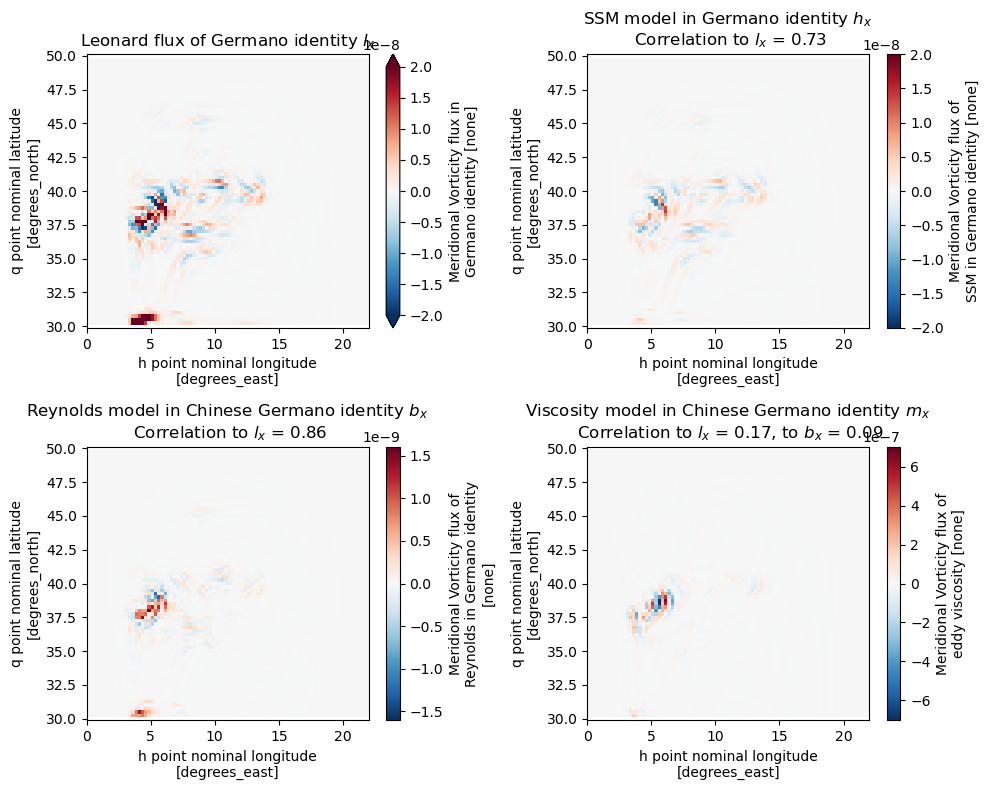

In [48]:
# Terms in Germano identity for two-parameter model
zl = 1
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
prog['leo_x'].isel(zl=zl).plot(vmin=-2e-8)
plt.title('Leonard flux of Germano identity $l_x$')

plt.subplot(2,2,2)
prog['h_x'].isel(zl=zl).plot(vmin=-2e-8)
corr = float(xr.corr(prog['leo_x'], prog['h_x'], ['xh','yq']).isel(Time=0,zl=zl))
plt.title('SSM model in Germano identity $h_x$ \n Correlation to $l_x$ = %.2f' % corr)

plt.subplot(2,2,3)
prog['bx'].isel(zl=zl).plot()
corr = float(xr.corr(prog['leo_x'], prog['bx'], ['xh','yq']).isel(Time=0,zl=zl))
plt.title('Reynolds model in Chinese Germano identity $b_x$ \n Correlation to $l_x$ = %.2f' % corr)

plt.subplot(2,2,4)
prog['m_x'].isel(zl=zl).plot()
corr = float(xr.corr(prog['leo_x'], prog['m_x'], ['xh','yq']).isel(Time=0,zl=zl))
corr1 = float(xr.corr(prog['bx'], prog['m_x'], ['xh','yq']).isel(Time=0,zl=zl))
plt.title('Viscosity model in Chinese Germano identity $m_x$ \n Correlation to $l_x$ = %.2f, to $b_x$ = %.2f' % (corr, corr1))

plt.tight_layout()

In [29]:
%time dyn = dyn_model(prog, static, ssm=True, reynolds=False)

CPU times: user 5.97 s, sys: 165 ms, total: 6.14 s
Wall time: 5.68 s


In [53]:
%time dyn = dyn_model_Chinese(prog, static, ssm=True, reynolds=True)

CPU times: user 4.44 s, sys: 95.6 ms, total: 4.53 s
Wall time: 4.28 s


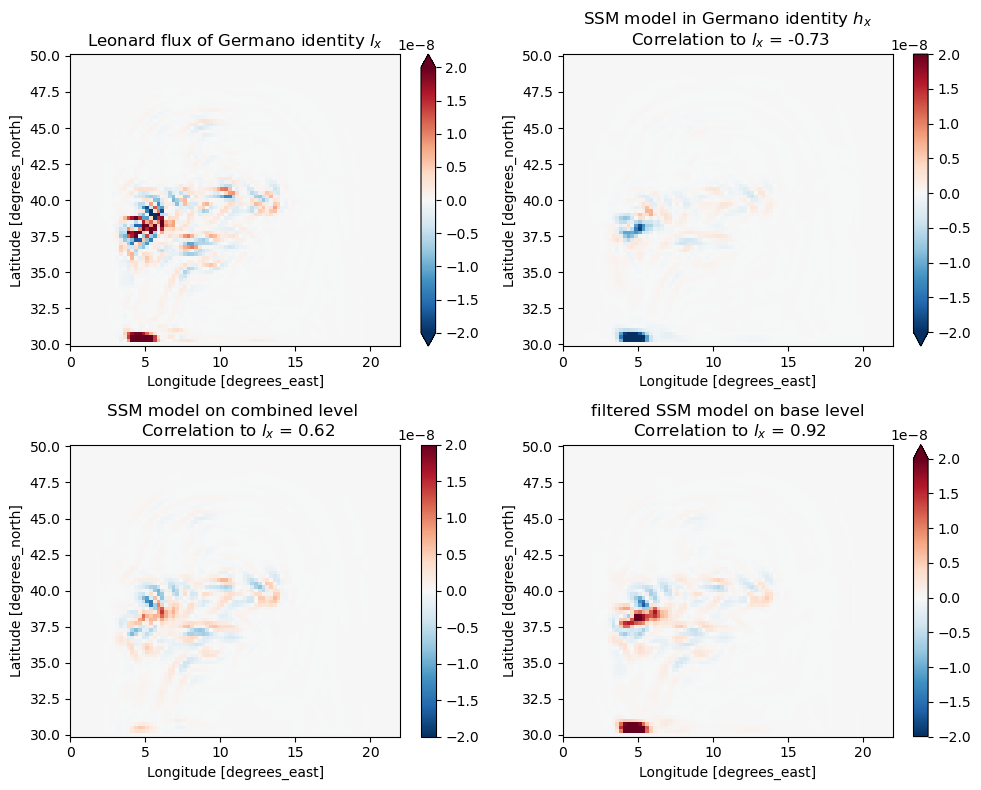

In [30]:
# Terms in Germano identity for two-parameter model
zl = 1
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
dyn['leo_x'].isel(zl=zl).plot(vmin=-2e-8)
plt.title('Leonard flux of Germano identity $l_x$')

plt.subplot(2,2,2)
dyn['h_x'].isel(zl=zl).plot(vmin=-2e-8)
corr = float(xr.corr(dyn['leo_x'], dyn['h_x'], ['xh','yq']).isel(Time=0,zl=zl))
plt.title('SSM model in Germano identity $h_x$ \n Correlation to $l_x$ = %.2f' % corr)

plt.subplot(2,2,3)
dyn['h_x_comb'].isel(zl=zl).plot(vmin=-2e-8)
corr = float(xr.corr(dyn['leo_x'], dyn['h_x_comb'], ['xh','yq']).isel(Time=0,zl=zl))
plt.title('SSM model on combined level \n Correlation to $l_x$ = %.2f' % corr)

plt.subplot(2,2,4)
dyn['h_x_basef'].isel(zl=zl).plot(vmin=-2e-8)
corr = float(xr.corr(dyn['leo_x'], dyn['h_x_basef'], ['xh','yq']).isel(Time=0,zl=zl))
plt.title('filtered SSM model on base level\n Correlation to $l_x$ = %.2f' % corr)

plt.tight_layout()

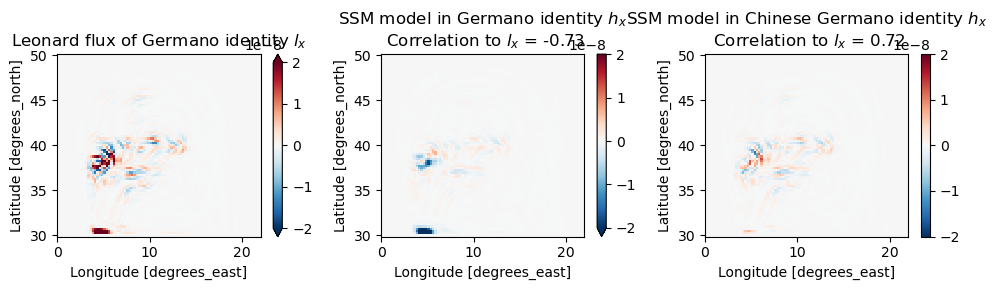

In [22]:
# Terms in Germano identity for two-parameter model
zl = 1
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
dyn['leo_x'].isel(zl=zl).plot(vmin=-2e-8)
plt.title('Leonard flux of Germano identity $l_x$')

plt.subplot(1,3,2)
dyn['h_x'].isel(zl=zl).plot(vmin=-2e-8)
corr = float(xr.corr(dyn['leo_x'], dyn['h_x'], ['xh','yq']).isel(Time=0,zl=zl))
plt.title('SSM model in Germano identity $h_x$ \n Correlation to $l_x$ = %.2f' % corr)

plt.subplot(1,3,3)
dyn_Chinese['h_x'].isel(zl=zl).plot(vmin=-2e-8)
corr = float(xr.corr(dyn['leo_x'], dyn_Chinese['h_x'], ['xh','yq']).isel(Time=0,zl=zl))
plt.title('SSM model in Chinese Germano identity $h_x$ \n Correlation to $l_x$ = %.2f' % corr)

plt.tight_layout()

In [42]:
print(dyn_Chinese['Cs_vort_flux_clip'].data)
print(dyn_Chinese['Cs_vort_flux_sum'].data) 
print(dyn_Chinese['CR_clip'].data)
print(dyn_Chinese['CR_sum'].data)

[[0.02887499 0.01841557]]
[[0.01547913 0.008841  ]]
[[18.34179802 15.78267892]]
[[18.51914168 15.83007899]]


In [37]:
print(dyn['Cs_vort_div_clip'].data)
print(dyn['Cs_vort_div_sum'].data)

[[0.03297162 0.01653262]]
[[0.01767691 0.01313283]]


In [38]:
print(dyn['Cs_mom_flux_clip'].data)
print(dyn['Cs_mom_flux_sum'].data)

[[0.06070961 0.03270849]]
[[0.02575715 0.00887959]]


In [43]:
series.smag_const.values

array([[0.03675175, 0.01529527],
       [0.03466382, 0.01498281],
       [0.03213609, 0.01530865],
       [0.03006419, 0.01717911],
       [0.02887499, 0.01841557]])

In [44]:
series.CR_const.values

array([[17.62587347, 15.46858255],
       [18.49967452, 15.75188841],
       [18.69570827, 16.35597703],
       [18.51636597, 16.44892994],
       [18.34179802, 15.78267892]])

# If Smagorinsky coefficient in different formulations similar? Let's compare mom_flux and vort_div

Answer: Smagorinsky coefficient is the same

In [200]:
dyn = dyn_model(prog, static, compute = lambda x: x)

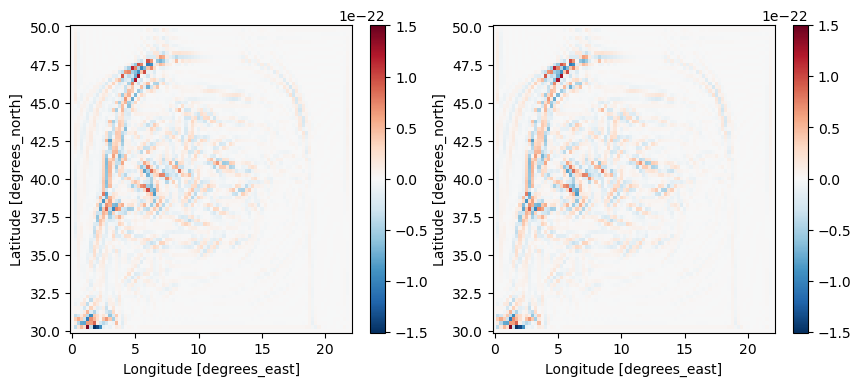

In [211]:
(np.abs(dyn['lap2_vort'] - dyn['diag_lap2vort']).mean() / np.abs(dyn['lap2_vort']).mean()).compute()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
dyn['lap2_vort'].isel(Time=-1,zl=0).plot()
plt.subplot(1,2,2)
dyn['diag_lap2vort'].isel(Time=-1,zl=0).plot()

/opt/ohpc/pub/compiler/anaconda3/2024.02-1/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


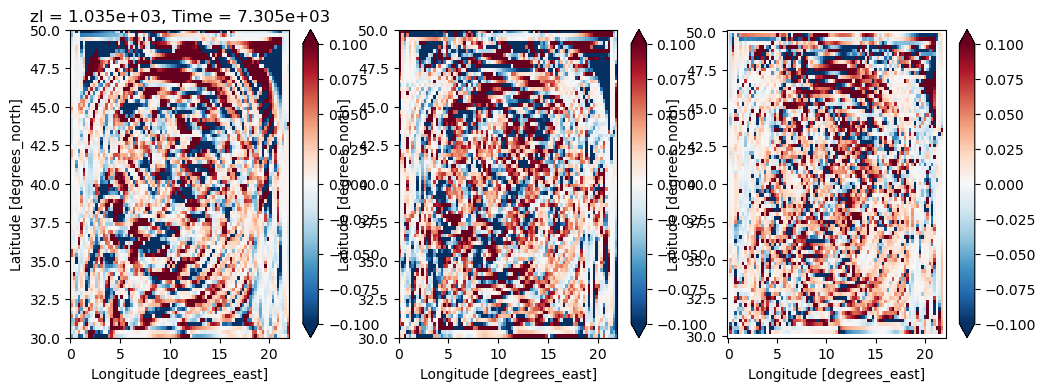

In [222]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
(dyn['lm_mom_flux'].isel(Time=-1,zl=0) / dyn['mm_mom_flux'].isel(Time=-1,zl=0)).plot(vmax=0.1)
plt.subplot(1,3,2)
(dyn['lm_vort_flux'].isel(Time=-1,zl=0) / dyn['mm_vort_flux'].isel(Time=-1,zl=0)).plot(vmax=0.1)
plt.subplot(1,3,3)
(dyn['lm_vort_div'].isel(Time=-1,zl=0) / dyn['mm_vort_div'].isel(Time=-1,zl=0)).plot(vmax=0.1)

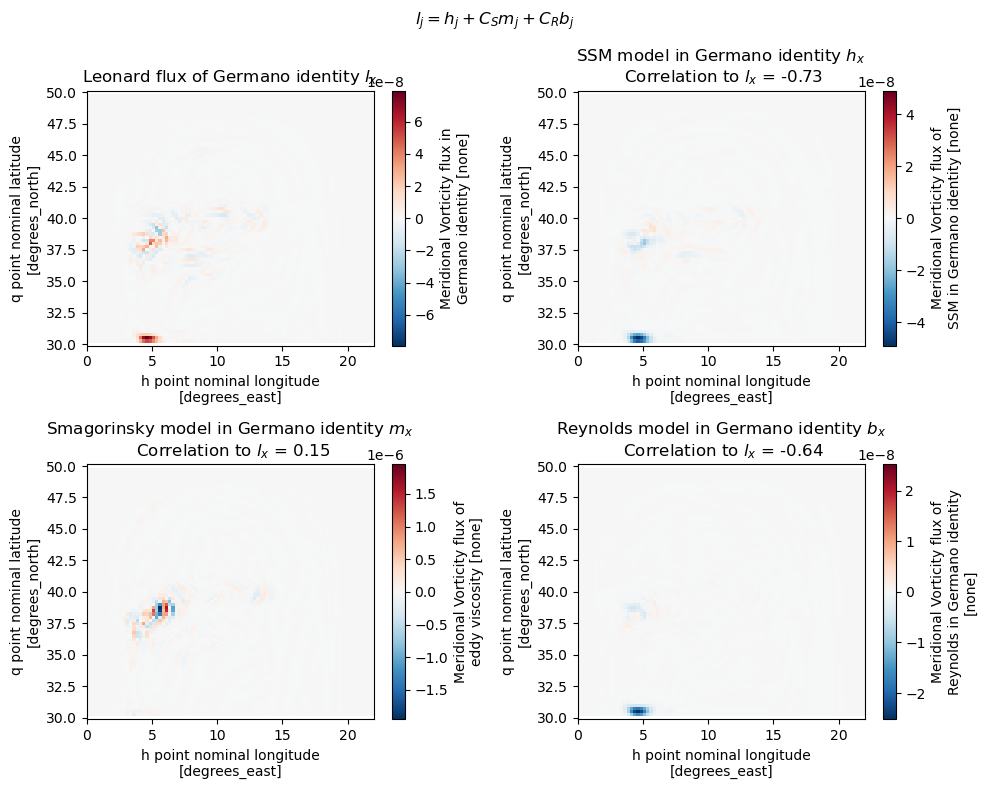

In [118]:
# Terms in Germano identity for two-parameter model
zl = 1
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
prog['leo_x'].isel(zl=zl).plot()
plt.title('Leonard flux of Germano identity $l_x$')

plt.subplot(2,2,2)
prog['h_x'].isel(zl=zl).plot()
corr = float(xr.corr(prog['leo_x'], prog['h_x'], ['xh','yq']).isel(Time=0,zl=zl))
plt.title('SSM model in Germano identity $h_x$ \n Correlation to $l_x$ = %.2f' % corr)

plt.subplot(2,2,3)
prog['m_x'].isel(zl=zl).plot()
corr = float(xr.corr(prog['leo_x'], prog['m_x'], ['xh','yq']).isel(Time=0,zl=zl))
plt.title('Smagorinsky model in Germano identity $m_x$ \n Correlation to $l_x$ = %.2f' % corr)

plt.subplot(2,2,4)
prog['bx'].isel(zl=zl).plot()
corr = float(xr.corr(prog['leo_x'], prog['bx'], ['xh','yq']).isel(Time=0,zl=zl))
plt.title('Reynolds model in Germano identity $b_x$ \n Correlation to $l_x$ = %.2f' % corr)

plt.suptitle('$l_j = h_j + C_S m_j + C_R b_j$')

plt.tight_layout()

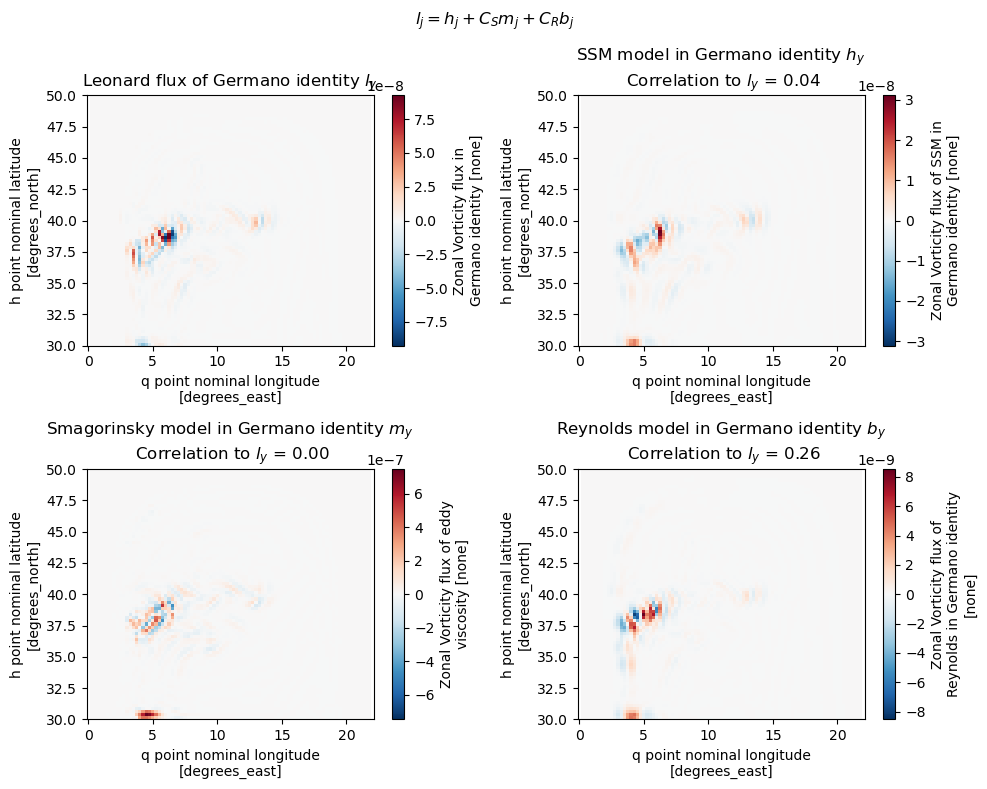

In [115]:
# Terms in Germano identity for two-parameter model
zl = 1
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
prog['leo_y'].isel(zl=zl).plot()
plt.title('Leonard flux of Germano identity $l_y$')

plt.subplot(2,2,2)
prog['h_y'].isel(zl=zl).plot()
corr = float(xr.corr(prog['leo_y'], prog['h_y'], ['xq','yh']).isel(Time=0,zl=zl))
plt.title('SSM model in Germano identity $h_y$ \n Correlation to $l_y$ = %.2f' % corr)

plt.subplot(2,2,3)
prog['m_y'].isel(zl=zl).plot()
corr = float(xr.corr(prog['leo_y'], prog['m_y'], ['xq','yh']).isel(Time=0,zl=zl))
plt.title('Smagorinsky model in Germano identity $m_y$ \n Correlation to $l_y$ = %.2f' % corr)

plt.subplot(2,2,4)
prog['by'].isel(zl=zl).plot()
corr = float(xr.corr(prog['leo_y'], prog['by'], ['xq','yh']).isel(Time=0,zl=zl))
plt.title('Reynolds model in Germano identity $b_y$ \n Correlation to $l_y$ = %.2f' % corr)

plt.suptitle('$l_j = h_j + C_S m_j + C_R b_j$')

plt.tight_layout()

Relative error: 1.3889903310173508e-15


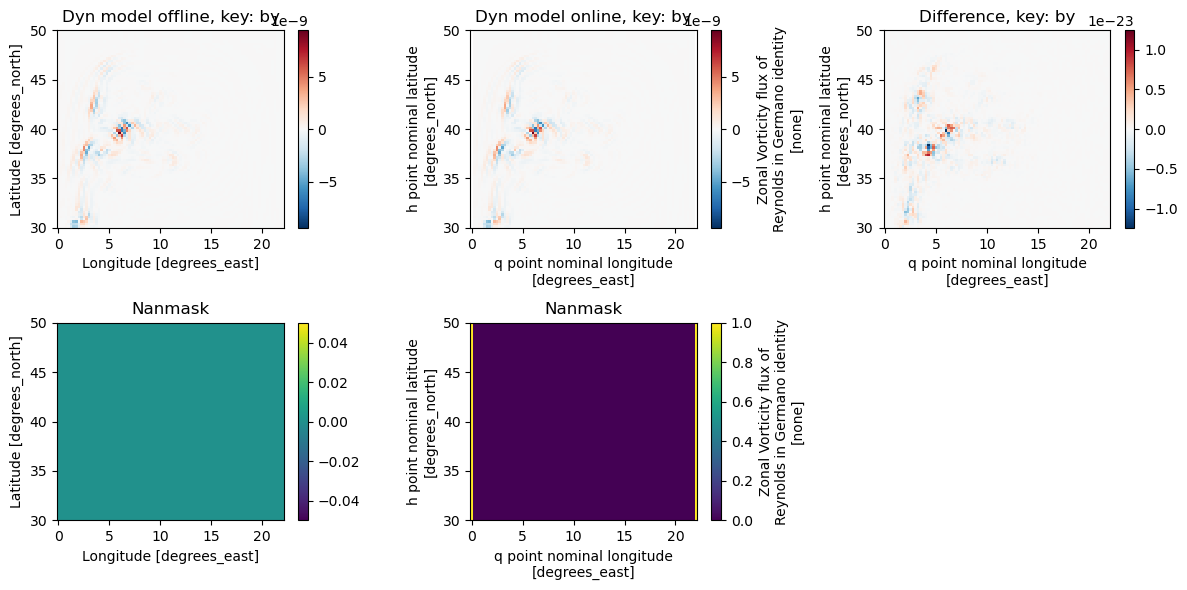

In [58]:
plt.figure(figsize=(12,6))
key = 'by'
key_dyn = 'by'
plt.subplot(2,3,1)
dyn[key_dyn].isel(Time=-1,zl=0).plot()
plt.title('Dyn model offline, key: ' + key)

plt.subplot(2,3,2)
prog[key].isel(Time=-1,zl=0).plot()
plt.title('Dyn model online, key: ' + key)

plt.subplot(2,3,3)
(prog[key].fillna(0.)-dyn[key_dyn]).isel(Time=-1,zl=0).plot()
plt.title('Difference, key: ' + key)

plt.subplot(2,3,4)
np.isnan(dyn[key_dyn]).isel(Time=-1,zl=0).plot()
plt.title('Nanmask')

plt.subplot(2,3,5)
np.isnan(prog[key]).isel(Time=-1,zl=0).plot()
plt.title('Nanmask')

error = float(np.abs(dyn[key_dyn]-prog[key].fillna(0.)).mean() / np.abs(prog[key].fillna(0.)).mean())
print('Relative error:', error)

plt.tight_layout()

In [188]:
prog = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/R8/DSM-kappa-sqrt-2-plus/prog*', decode_times=False)
pg23 = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/R8/DSM-kappa-sqrt-2-plus/pg23*', decode_times=False)
static = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/R8/DSM-kappa-sqrt-2-plus/ocean_geometry.nc', decode_times=False).rename(
    {'lath': 'yh', 'latq':'yq', 'lonh':'xh', 'lonq':'xq'})
series = xr.open_mfdataset('/home/ctrsp-2024/pp2681/experiments/R8/DSM-kappa-sqrt-2-plus/series*', decode_times=False)

In [189]:
%time dyn = dyn_model(prog, static)

CPU times: user 7min 48s, sys: 22.7 s, total: 8min 10s
Wall time: 1min 3s


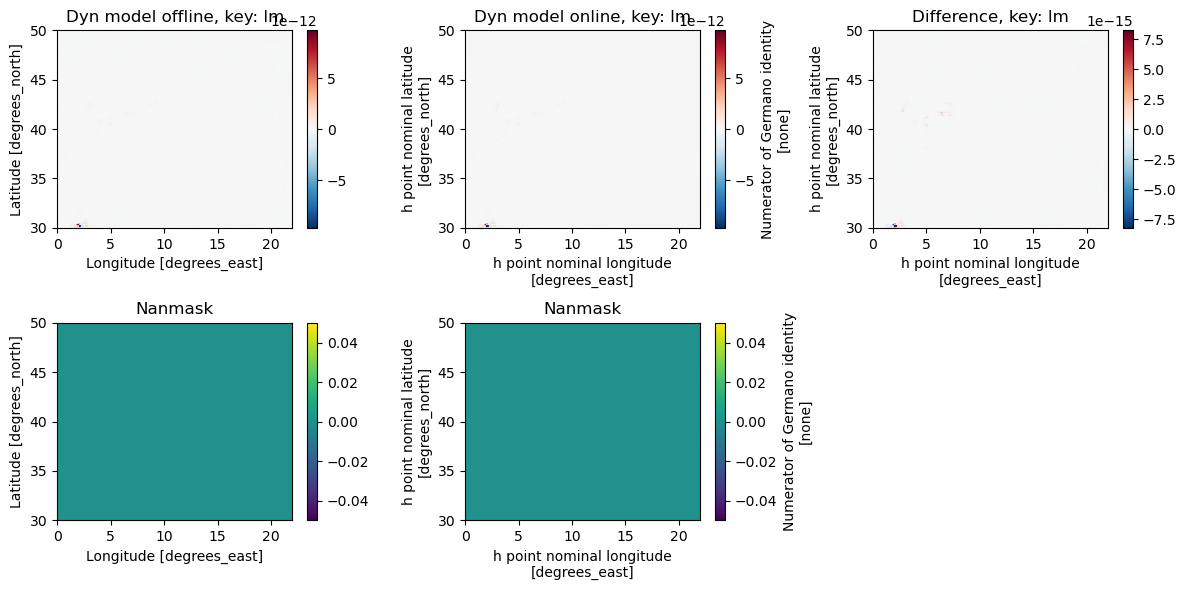

In [19]:
plt.figure(figsize=(12,6))
key = 'lm'
key_dyn = 'lm_vort_flux'
plt.subplot(2,3,1)
dyn[key_dyn].isel(Time=-1,zl=0).plot()
plt.title('Dyn model offline, key: ' + key)

plt.subplot(2,3,2)
prog[key].isel(Time=-1,zl=0).plot()
plt.title('Dyn model online, key: ' + key)

plt.subplot(2,3,3)
(prog[key].fillna(0.)-dyn[key_dyn]).isel(Time=-1,zl=0).plot()
plt.title('Difference, key: ' + key)

plt.subplot(2,3,4)
np.isnan(dyn[key_dyn]).isel(Time=-1,zl=0).plot()
plt.title('Nanmask')

plt.subplot(2,3,5)
np.isnan(prog[key]).isel(Time=-1,zl=0).plot()
plt.title('Nanmask')

plt.tight_layout()

(0.0, 0.04)

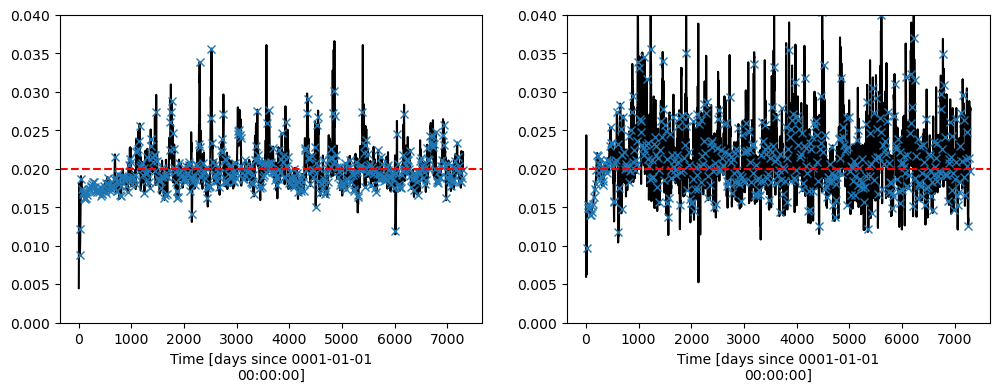

In [190]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
series.smag_const.isel(zl=0).plot(color='k')
dyn['Cs_vort_flux_clip'].isel(zl=0).plot(ls='', marker='x')
#plt.xlim([7000,7300])
plt.axhline(y=0.02, color='r', ls='--')
plt.ylim([0,0.04])

plt.subplot(1,2,2)
series.smag_const.isel(zl=1).plot(color='k')
dyn['Cs_vort_flux_clip'].isel(zl=1).plot(ls='', marker='x')
#plt.xlim([7000,7300])
plt.axhline(y=0.02, color='r', ls='--')
plt.ylim([0,0.04])

In [45]:
prog, static = read_data('R4')

In [46]:
dyn_R4 = dyn_model(prog, static, reduce='clip')

In [48]:
from dask.diagnostics import ProgressBar
%time Cs_R4 = dyn_R4['Cs'].compute()

CPU times: user 1min 25s, sys: 4.33 s, total: 1min 29s
Wall time: 1min 19s


(0.0, 0.04)

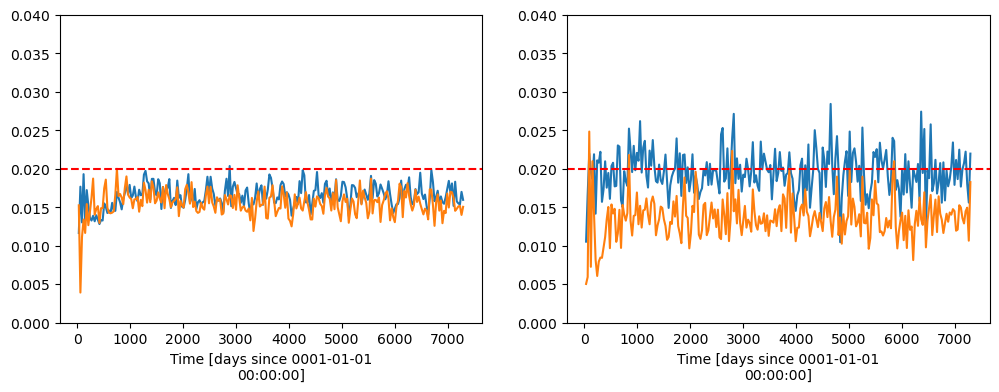

In [41]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
#series.smag_const.isel(zl=0).plot(color='k')
Cs.isel(zl=0).plot()
Cs_R4.isel(zl=0).plot()
#plt.xlim([7000,7300])
plt.axhline(y=0.02, color='r', ls='--')
plt.ylim([0,0.04])

plt.subplot(1,2,2)
#series.smag_const.isel(zl=1).plot(color='k')
Cs.isel(zl=1).plot()
Cs_R4.isel(zl=1).plot()
#plt.xlim([7000,7300])
plt.axhline(y=0.02, color='r', ls='--')
plt.ylim([0,0.04])

# A priori analysis of dynamic biharmonic Smagorinsky model

In [235]:
ds = xr.Dataset()
for RR in ['R2', 'R4', 'R8', 'R16']:
    prog, static = read_data(RR)
    %time dyn = dyn_model(prog, static)
    for key in ['Cs_vort_flux_sum', 'Cs_vort_flux_clip', 'Cs_vort_div_sum', 'Cs_vort_div_clip', 'Cs_mom_flux_sum', 'Cs_mom_flux_clip']:
        ds[f'{RR}_{key}'] = dyn[key]

CPU times: user 21.5 s, sys: 708 ms, total: 22.2 s
Wall time: 11.8 s
CPU times: user 55.4 s, sys: 2.19 s, total: 57.6 s
Wall time: 12.9 s
CPU times: user 3min 45s, sys: 15.1 s, total: 4min
Wall time: 25.4 s
CPU times: user 17min 28s, sys: 5min 39s, total: 23min 8s
Wall time: 1min 27s


In [236]:
ds.to_netcdf('a-priori/bihDSM-kappa-sqrt2-tf-sqrt6.nc')

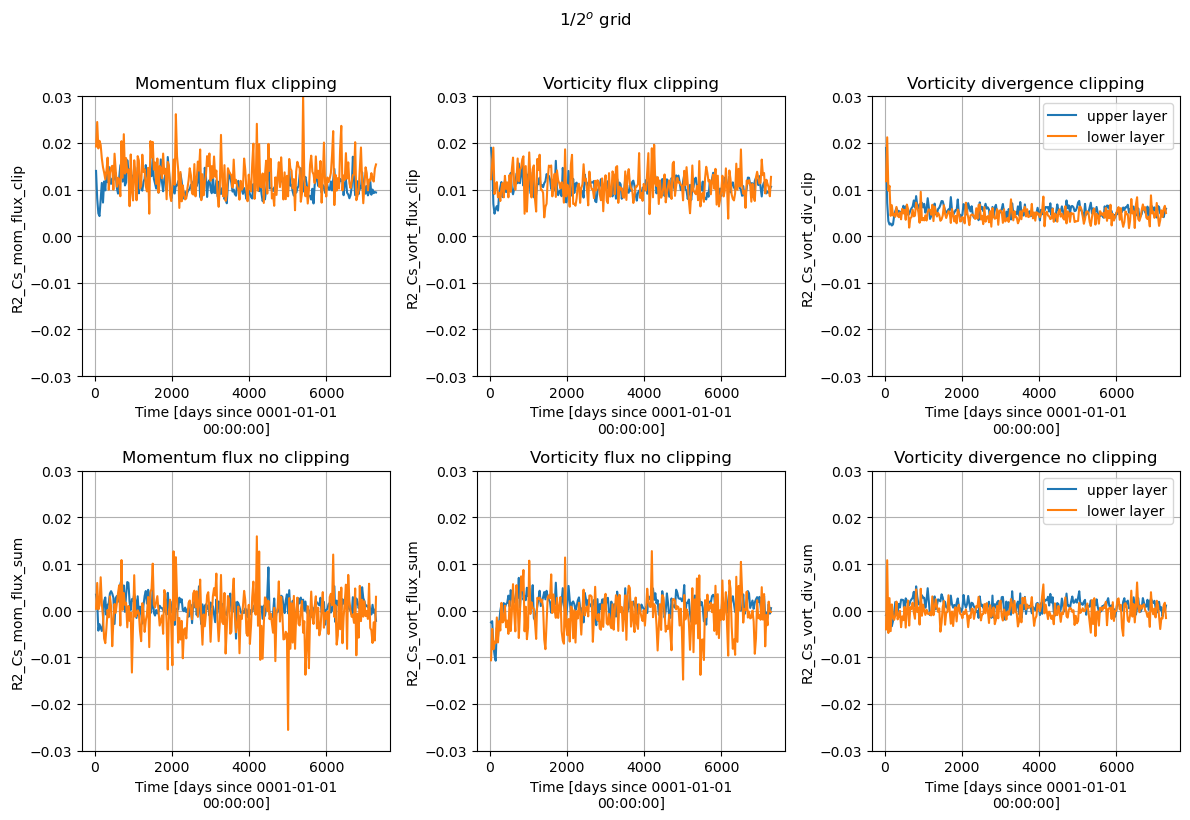

In [268]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
ds['R2_Cs_mom_flux_clip'].isel(zl=0).plot(label='upper layer')
ds['R2_Cs_mom_flux_clip'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Momentum flux clipping')

plt.subplot(2,3,2)
ds['R2_Cs_vort_flux_clip'].isel(zl=0).plot(label='upper layer')
ds['R2_Cs_vort_flux_clip'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity flux clipping')

plt.subplot(2,3,3)
ds['R2_Cs_vort_div_clip'].isel(zl=0).plot(label='upper layer')
ds['R2_Cs_vort_div_clip'].isel(zl=1).plot(label='lower layer')
plt.legend()
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity divergence clipping')

plt.subplot(2,3,4)
ds['R2_Cs_mom_flux_sum'].isel(zl=0).plot(label='upper layer')
ds['R2_Cs_mom_flux_sum'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Momentum flux no clipping')

plt.subplot(2,3,5)
ds['R2_Cs_vort_flux_sum'].isel(zl=0).plot(label='upper layer')
ds['R2_Cs_vort_flux_sum'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity flux no clipping')

plt.subplot(2,3,6)
ds['R2_Cs_vort_div_sum'].isel(zl=0).plot(label='upper layer')
ds['R2_Cs_vort_div_sum'].isel(zl=1).plot(label='lower layer')
plt.legend()
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity divergence no clipping')

plt.suptitle('$1/2^o$ grid', y = 1.02)

plt.tight_layout()

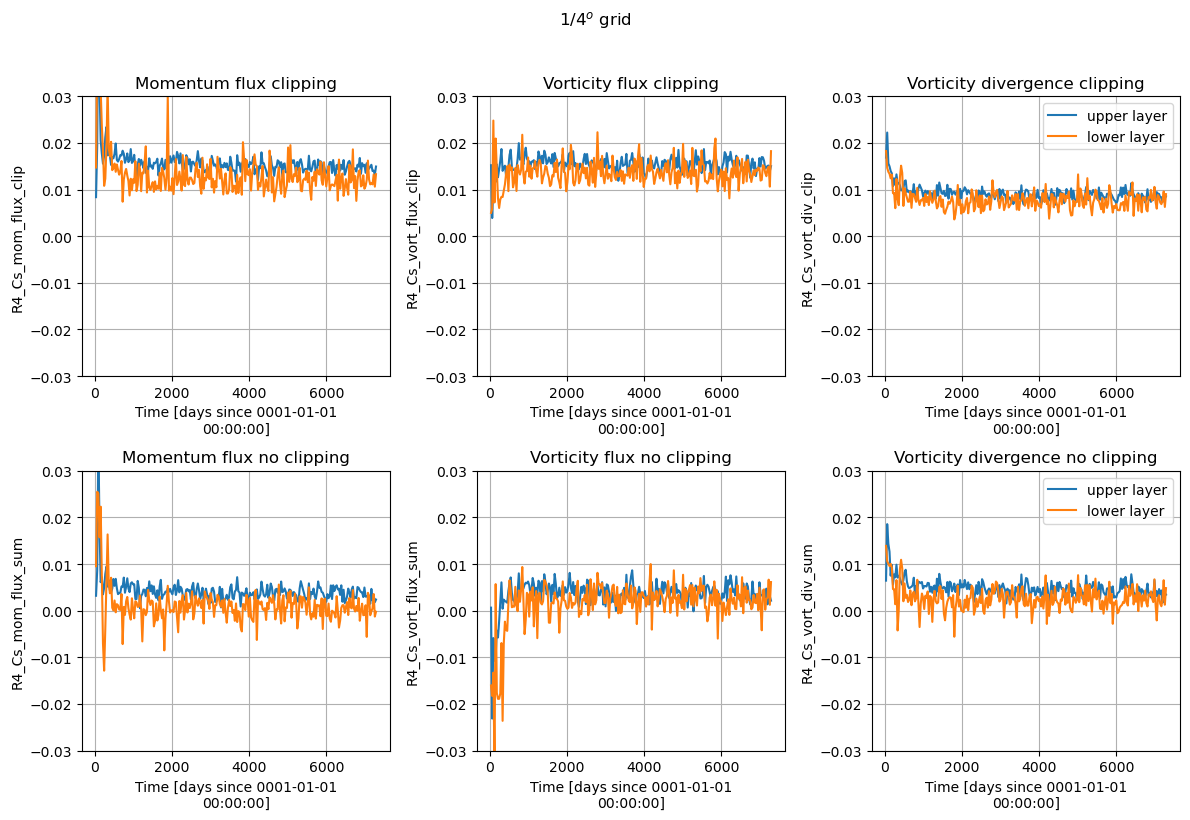

In [269]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
ds['R4_Cs_mom_flux_clip'].isel(zl=0).plot(label='upper layer')
ds['R4_Cs_mom_flux_clip'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Momentum flux clipping')

plt.subplot(2,3,2)
ds['R4_Cs_vort_flux_clip'].isel(zl=0).plot(label='upper layer')
ds['R4_Cs_vort_flux_clip'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity flux clipping')

plt.subplot(2,3,3)
ds['R4_Cs_vort_div_clip'].isel(zl=0).plot(label='upper layer')
ds['R4_Cs_vort_div_clip'].isel(zl=1).plot(label='lower layer')
plt.legend()
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity divergence clipping')

plt.subplot(2,3,4)
ds['R4_Cs_mom_flux_sum'].isel(zl=0).plot(label='upper layer')
ds['R4_Cs_mom_flux_sum'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Momentum flux no clipping')

plt.subplot(2,3,5)
ds['R4_Cs_vort_flux_sum'].isel(zl=0).plot(label='upper layer')
ds['R4_Cs_vort_flux_sum'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity flux no clipping')

plt.subplot(2,3,6)
ds['R4_Cs_vort_div_sum'].isel(zl=0).plot(label='upper layer')
ds['R4_Cs_vort_div_sum'].isel(zl=1).plot(label='lower layer')
plt.legend()
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity divergence no clipping')

plt.suptitle('$1/4^o$ grid', y = 1.02)

plt.tight_layout()

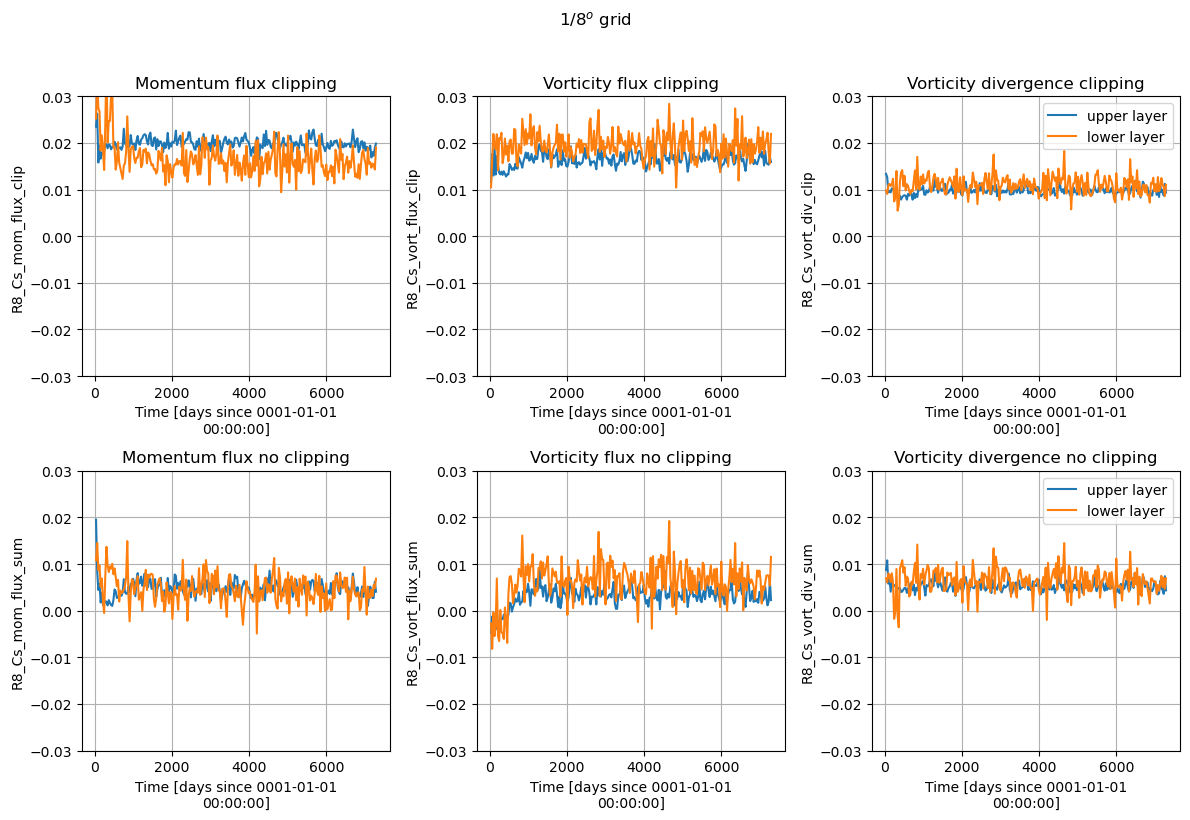

In [270]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
ds['R8_Cs_mom_flux_clip'].isel(zl=0).plot(label='upper layer')
ds['R8_Cs_mom_flux_clip'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Momentum flux clipping')

plt.subplot(2,3,2)
ds['R8_Cs_vort_flux_clip'].isel(zl=0).plot(label='upper layer')
ds['R8_Cs_vort_flux_clip'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity flux clipping')

plt.subplot(2,3,3)
ds['R8_Cs_vort_div_clip'].isel(zl=0).plot(label='upper layer')
ds['R8_Cs_vort_div_clip'].isel(zl=1).plot(label='lower layer')
plt.legend()
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity divergence clipping')

plt.subplot(2,3,4)
ds['R8_Cs_mom_flux_sum'].isel(zl=0).plot(label='upper layer')
ds['R8_Cs_mom_flux_sum'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Momentum flux no clipping')

plt.subplot(2,3,5)
ds['R8_Cs_vort_flux_sum'].isel(zl=0).plot(label='upper layer')
ds['R8_Cs_vort_flux_sum'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity flux no clipping')

plt.subplot(2,3,6)
ds['R8_Cs_vort_div_sum'].isel(zl=0).plot(label='upper layer')
ds['R8_Cs_vort_div_sum'].isel(zl=1).plot(label='lower layer')
plt.legend()
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity divergence no clipping')

plt.suptitle('$1/8^o$ grid', y = 1.02)

plt.tight_layout()

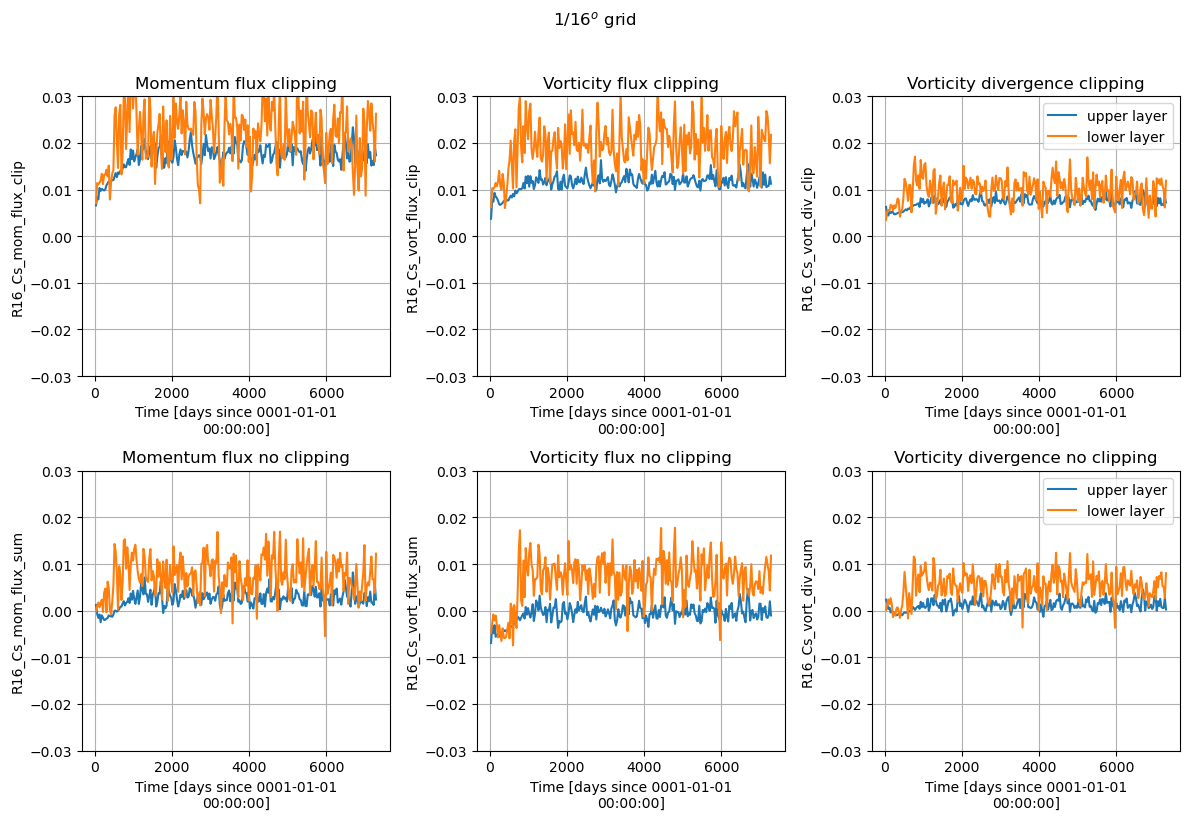

In [271]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
ds['R16_Cs_mom_flux_clip'].isel(zl=0).plot(label='upper layer')
ds['R16_Cs_mom_flux_clip'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Momentum flux clipping')

plt.subplot(2,3,2)
ds['R16_Cs_vort_flux_clip'].isel(zl=0).plot(label='upper layer')
ds['R16_Cs_vort_flux_clip'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity flux clipping')

plt.subplot(2,3,3)
ds['R16_Cs_vort_div_clip'].isel(zl=0).plot(label='upper layer')
ds['R16_Cs_vort_div_clip'].isel(zl=1).plot(label='lower layer')
plt.legend()
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity divergence clipping')

plt.subplot(2,3,4)
ds['R16_Cs_mom_flux_sum'].isel(zl=0).plot(label='upper layer')
ds['R16_Cs_mom_flux_sum'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Momentum flux no clipping')

plt.subplot(2,3,5)
ds['R16_Cs_vort_flux_sum'].isel(zl=0).plot(label='upper layer')
ds['R16_Cs_vort_flux_sum'].isel(zl=1).plot(label='lower layer')
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity flux no clipping')

plt.subplot(2,3,6)
ds['R16_Cs_vort_div_sum'].isel(zl=0).plot(label='upper layer')
ds['R16_Cs_vort_div_sum'].isel(zl=1).plot(label='lower layer')
plt.legend()
plt.ylim([-0.03,0.03])
plt.grid()
plt.title('Vorticity divergence no clipping')

plt.suptitle('$1/16^o$ grid', y = 1.02)

plt.tight_layout()

# Summary
* On average, flux and clip versions of dynamic procedure for all formulations predict the positive biharmonic Smagorinsky coefficient
* The clipped predictions are on average twice larger than the non-clipped predictions
* Divergence formulation does not seem to predict bigger Smagorinsky coefficient
* Momentum flux clipped and vorticity flux clipped estimators are similar
* Unclipped predictions in an inertial range are too small and unrelizable. So, fair (without clipping) dynamic estimation is probably not possible.

# Why most of the predictions give positive Smagorinsky coefficient? Test with laplacian Smagorinsky model

In [274]:
def dyn_lap_model(prog, static, tf_width=np.sqrt(6), tf_iter=1, filters_ratio=np.sqrt(2), compute=lambda x: x.compute()):
    grid = xgcm.Grid(static, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}},
            boundary={'X': 'fill', 'Y': 'fill'},
            fill_value = {'X': 0, 'Y': 0})
    static['wet_u']=np.floor(grid.interp(static.wet,'X'))
    static['wet_v']=np.floor(grid.interp(static.wet,'Y'))
    static['wet_c']=np.floor(grid.interp(static.wet,['X','Y']))

    dx2q = static.dxBu**2 ; dy2q = static.dyBu**2
    grid_sp_q2 = ((2.0*dx2q*dy2q) / (dx2q+dy2q))

    u = (prog.u * static.wet_u).fillna(0.).astype('float64')
    v = (prog.v * static.wet_v).fillna(0.).astype('float64')
    
    # Model in vorticity fluxes
    uf = filter_iteration(u, static.wet_u, 'xq', 'yh', tf_iter, tf_width)
    vf = filter_iteration(v, static.wet_v, 'xh', 'yq', tf_iter, tf_width)

    sh_xx, sh_xy, shear_mag, vort_xy = compute_velocity_gradients(u, v, static, grid)
    sh_xxf, sh_xyf, shear_magf, vort_xyf = compute_velocity_gradients(uf, vf, static, grid)

    vort_x, vort_y, lap_vort, _, _ = compute_vorticity_gradients(vort_xy, static, grid)
    vort_xf, vort_yf, lap_vortf, _, _ = compute_vorticity_gradients(vort_xyf, static, grid)

    smag_x = - vort_x * grid.interp(shear_mag * grid_sp_q2,'X')
    smag_y = - vort_y * grid.interp(shear_mag * grid_sp_q2,'Y')

    smag_x = filter_iteration(smag_x, static.wet_v, 'xh', 'yq', tf_iter, tf_width)
    smag_y = filter_iteration(smag_y, static.wet_u, 'xq', 'yh', tf_iter, tf_width)

    smag_xf = -(filters_ratio)**2 * vort_xf * grid.interp(shear_magf * grid_sp_q2,'X')
    smag_yf = -(filters_ratio)**2 * vort_yf * grid.interp(shear_magf * grid_sp_q2,'Y')

    m_x = smag_xf - smag_x
    m_y = smag_yf - smag_y

    leo_x = filter_iteration(grid.interp(u,['X','Y']) * grid.interp(vort_xy,'X'), static.wet_v, 'xh', 'yq', tf_iter, tf_width) - \
            grid.interp(uf,['X','Y']) * grid.interp(vort_xyf,'X')
    leo_x = leo_x * static.wet_v
    
    leo_y = filter_iteration(grid.interp(v,['X','Y']) * grid.interp(vort_xy,'Y'), static.wet_u, 'xq','yh', tf_iter, tf_width) - \
            grid.interp(vf,['X','Y']) * grid.interp(vort_xyf,'Y')
    leo_y = leo_y * static.wet_u

    mm_vort_flux = grid.interp(m_x**2, 'Y') + grid.interp(m_y**2,'X')
    lm_vort_flux = grid.interp(leo_x*m_x,'Y') + grid.interp(leo_y*m_y,'X')

    Cs_vort_flux_sum = ((lm_vort_flux * static.dxT * static.dyT).sum(['xh', 'yh']) / (mm_vort_flux * static.dxT * static.dyT).sum(['xh', 'yh'])); 
    Cs_vort_flux_sum['Time'] = u.Time
    Cs_vort_flux_clip = ((np.maximum(lm_vort_flux,0.0) * static.dxT * static.dyT).sum(['xh', 'yh']) / (mm_vort_flux * static.dxT * static.dyT).sum(['xh', 'yh']))
    Cs_vort_flux_clip['Time'] = u.Time

    # Model in divergence of vorticity fluxes
    smag = - shear_mag * grid_sp_q2 * lap_vort
    smag = filter_iteration(smag, static.wet_c, 'xq', 'yq', tf_iter, tf_width)
    smagf = - (filters_ratio)**2 * shear_magf * grid_sp_q2 * lap_vortf
    m = smagf - smag

    # Divergence of leonard vorticity flux
    leo = (grid.diff(leo_x * static.dyCv,'X') + grid.diff(leo_y * static.dxCu, 'Y')) * static.wet_c / (static.dxBu * static.dyBu)

    mm_vort_div = m * m
    lm_vort_div = leo * m

    Cs_vort_div_sum = ((lm_vort_div * static.dxBu * static.dyBu).sum(['xq', 'yq']) / (mm_vort_div * static.dxBu * static.dyBu).sum(['xq', 'yq'])); 
    Cs_vort_div_sum['Time'] = u.Time
    Cs_vort_div_clip = ((np.maximum(lm_vort_div, 0.0) * static.dxBu * static.dyBu).sum(['xq', 'yq']) / (mm_vort_div * static.dxBu * static.dyBu).sum(['xq', 'yq']))
    Cs_vort_div_clip['Time'] = u.Time 

    # Momentum flux
    Del2u, Del2v = divergence_momentum_flux(sh_xx, sh_xy, -sh_xx, static, grid)
    Del2uf, Del2vf = divergence_momentum_flux(sh_xxf, sh_xyf, -sh_xxf, static, grid)

    lap_sh_xx, lap_sh_xy, _, _ = compute_velocity_gradients(Del2u, Del2v, static, grid)
    lap_sh_xxf, lap_sh_xyf, _, _ = compute_velocity_gradients(Del2uf, Del2vf, static, grid)
    
    Txy = -grid_sp_q2 * shear_mag * sh_xy
    Txx = -grid.interp(grid_sp_q2 * shear_mag, ['X', 'Y']) * sh_xx
    Txy = filter_iteration(Txy, static.wet_c, 'xq', 'yq', tf_iter, tf_width)
    Txx = filter_iteration(Txx, static.wet, 'xh', 'yh', tf_iter, tf_width)

    Txyf = -(filters_ratio)**2 * grid_sp_q2 * shear_magf * sh_xyf
    Txxf = -(filters_ratio)**2 * grid.interp(grid_sp_q2 * shear_magf, ['X', 'Y']) * sh_xxf

    # Diagnostic output to compare definitions of Smagorinsky coefficient
    diag_x, diag_y = divergence_momentum_flux(sh_xx, sh_xy, -sh_xx, static, grid)
    diag_lapvort = (grid.diff(diag_y * static.wet_v * static.dyCv, 'X') - grid.diff(diag_x * static.wet_u * static.dxCu, 'Y')) * static.wet_c / (static.dxBu * static.dyBu)

    m_xx = Txxf - Txx
    m_xy = Txyf - Txy
    m_yy = -m_xx

    leo_xx = grid.interp(filter_iteration(u**2, static.wet_u, 'xq', 'yh', tf_iter, tf_width) - uf**2, 'X') * static.wet
    leo_yy = grid.interp(filter_iteration(v**2, static.wet_v, 'xh', 'yq', tf_iter, tf_width) - vf**2, 'Y') * static.wet
    leo_xy = filter_iteration(grid.interp(u,'Y') * grid.interp(v,'X'), static.wet_c, 'xq', 'yq', tf_iter, tf_width) - \
             grid.interp(uf,'Y') * grid.interp(vf,'X') * static.wet_c

    lm_mom_flux = leo_xx * m_xx + leo_yy * m_yy + grid.interp(leo_xy * m_xy * 2, ['X', 'Y']) * static.wet
    mm_mom_flux = m_xx * m_xx + m_yy * m_yy + grid.interp(m_xy * m_xy * 2, ['X', 'Y']) * static.wet

    Cs_mom_flux_sum = ((lm_mom_flux * static.dxT * static.dyT).sum(['xh', 'yh']) / (mm_mom_flux * static.dxT * static.dyT).sum(['xh', 'yh'])); 
    Cs_mom_flux_sum['Time'] = u.Time
    Cs_mom_flux_clip = ((np.maximum(lm_mom_flux, 0.) * static.dxT * static.dyT).sum(['xh', 'yh']) / (mm_mom_flux * static.dxT * static.dyT).sum(['xh', 'yh'])); 
    Cs_mom_flux_clip['Time'] = u.Time 
    
    

    return {'u':u, 'v': v, 'uf': uf, 'vf': vf,
            'sh_xx': sh_xx, 'sh_xy': sh_xy, 'shear_mag': shear_mag, 'vort_xy': vort_xy,
            'sh_xxf': sh_xxf, 'sh_xyf': sh_xyf, 'shear_magf': shear_magf, 'vort_xyf': vort_xyf,
            'vort_x': vort_x, 'vort_y': vort_y, 'lap_vort': lap_vort,
            'vort_xf': vort_xf, 'vort_yf': vort_yf, 'lap_vortf': lap_vortf,
            'smag_x': smag_x, 'smag_y': smag_y,
            'smag_xf': smag_xf, 'smag_yf': smag_yf,
            'Txxf': Txxf, 'Tyyf': Txxf,
            'smag': smag, 'smagf': smagf,
            'diag_lapvort': diag_lapvort,
            'm_x' : m_x, 'm_y': m_y,
            'leo_x': leo_x, 'leo_y': leo_y,
            'm': m, 'leo': leo,
            'm_xx': m_xx, 'm_xy': m_xy, 'm_yy': m_yy, 
            'leo_xx': leo_xx, 'leo_xy': leo_xy, 'leo_yy': leo_yy,
            'lm_vort_flux': lm_vort_flux, 'mm_vort_flux': mm_vort_flux,
            'lm_vort_div': lm_vort_div, 'mm_vort_div': mm_vort_div,
            'lm_mom_flux': lm_mom_flux, 'mm_mom_flux': mm_mom_flux,
            'Cs_vort_flux_sum': compute(Cs_vort_flux_sum), 'Cs_vort_flux_clip': compute(Cs_vort_flux_clip),
            'Cs_vort_div_sum': compute(Cs_vort_div_sum), 'Cs_vort_div_clip': compute(Cs_vort_div_clip),
            'Cs_mom_flux_sum': compute(Cs_mom_flux_sum), 'Cs_mom_flux_clip': compute(Cs_mom_flux_clip)
           }

In [276]:
dyn = dyn_lap_model(prog,static, compute=lambda x: x)

In [278]:
(np.abs(dyn['lap_vort'] - dyn['diag_lapvort']).mean() / np.abs(dyn['lap_vort']).mean()).compute()

<xarray.DataArray ()>
array(3.03815236e-05)

In [295]:
ds_lap = xr.Dataset()
for RR in ['R2', 'R4', 'R8', 'R16']:
    prog, static = read_data(RR)
    %time dyn = dyn_lap_model(prog, static)
    for key in ['Cs_vort_flux_sum', 'Cs_vort_flux_clip', 'Cs_vort_div_sum', 'Cs_vort_div_clip', 'Cs_mom_flux_sum', 'Cs_mom_flux_clip']:
        ds_lap[f'{RR}_{key}'] = dyn[key]

CPU times: user 20 s, sys: 815 ms, total: 20.8 s
Wall time: 11.5 s
CPU times: user 50.8 s, sys: 1.99 s, total: 52.8 s
Wall time: 13.3 s
CPU times: user 3min 16s, sys: 12.9 s, total: 3min 29s
Wall time: 21.2 s
CPU times: user 14min 29s, sys: 4min 22s, total: 18min 52s
Wall time: 1min 10s


In [296]:
ds_lap.to_netcdf('a-priori/lapDSM-kappa-sqrt2-tf-sqrt6.nc')

In [19]:
def plot_Cs(ds, RR='R2', ylim=0.03):
    plt.figure(figsize=(12,8))
    plt.subplot(2,3,1)
    ds[f'{RR}_Cs_mom_flux_clip'].isel(zl=0).plot(label='upper layer')
    ds[f'{RR}_Cs_mom_flux_clip'].isel(zl=1).plot(label='lower layer')
    plt.ylim([-ylim,ylim])
    plt.grid()
    plt.title('Momentum flux clipping')
    
    plt.subplot(2,3,2)
    ds[f'{RR}_Cs_vort_flux_clip'].isel(zl=0).plot(label='upper layer')
    ds[f'{RR}_Cs_vort_flux_clip'].isel(zl=1).plot(label='lower layer')
    plt.ylim([-ylim,ylim])
    plt.grid()
    plt.title('Vorticity flux clipping')
    
    plt.subplot(2,3,3)
    ds[f'{RR}_Cs_vort_div_clip'].isel(zl=0).plot(label='upper layer')
    ds[f'{RR}_Cs_vort_div_clip'].isel(zl=1).plot(label='lower layer')
    plt.legend()
    plt.ylim([-ylim,ylim])
    plt.grid()
    plt.title('Vorticity divergence clipping')
    
    plt.subplot(2,3,4)
    ds[f'{RR}_Cs_mom_flux_sum'].isel(zl=0).plot(label='upper layer')
    ds[f'{RR}_Cs_mom_flux_sum'].isel(zl=1).plot(label='lower layer')
    plt.ylim([-ylim,ylim])
    plt.grid()
    plt.title('Momentum flux no clipping')
    
    plt.subplot(2,3,5)
    ds[f'{RR}_Cs_vort_flux_sum'].isel(zl=0).plot(label='upper layer')
    ds[f'{RR}_Cs_vort_flux_sum'].isel(zl=1).plot(label='lower layer')
    plt.ylim([-ylim,ylim])
    plt.grid()
    plt.title('Vorticity flux no clipping')
    
    plt.subplot(2,3,6)
    ds[f'{RR}_Cs_vort_div_sum'].isel(zl=0).plot(label='upper layer')
    ds[f'{RR}_Cs_vort_div_sum'].isel(zl=1).plot(label='lower layer')
    plt.legend()
    plt.ylim([-ylim,ylim])
    plt.grid()
    plt.title('Vorticity divergence no clipping')
    
    plt.suptitle(f'$1/{RR[1:]}^o$ grid', y = 1.02)
    
    plt.tight_layout()

In [297]:
ds = xr.open_dataset('a-priori/bihDSM-kappa-sqrt2-tf-sqrt6.nc', decode_times=False)
ds_lap = xr.open_dataset('a-priori/lapDSM-kappa-sqrt2-tf-sqrt6.nc', decode_times=False)

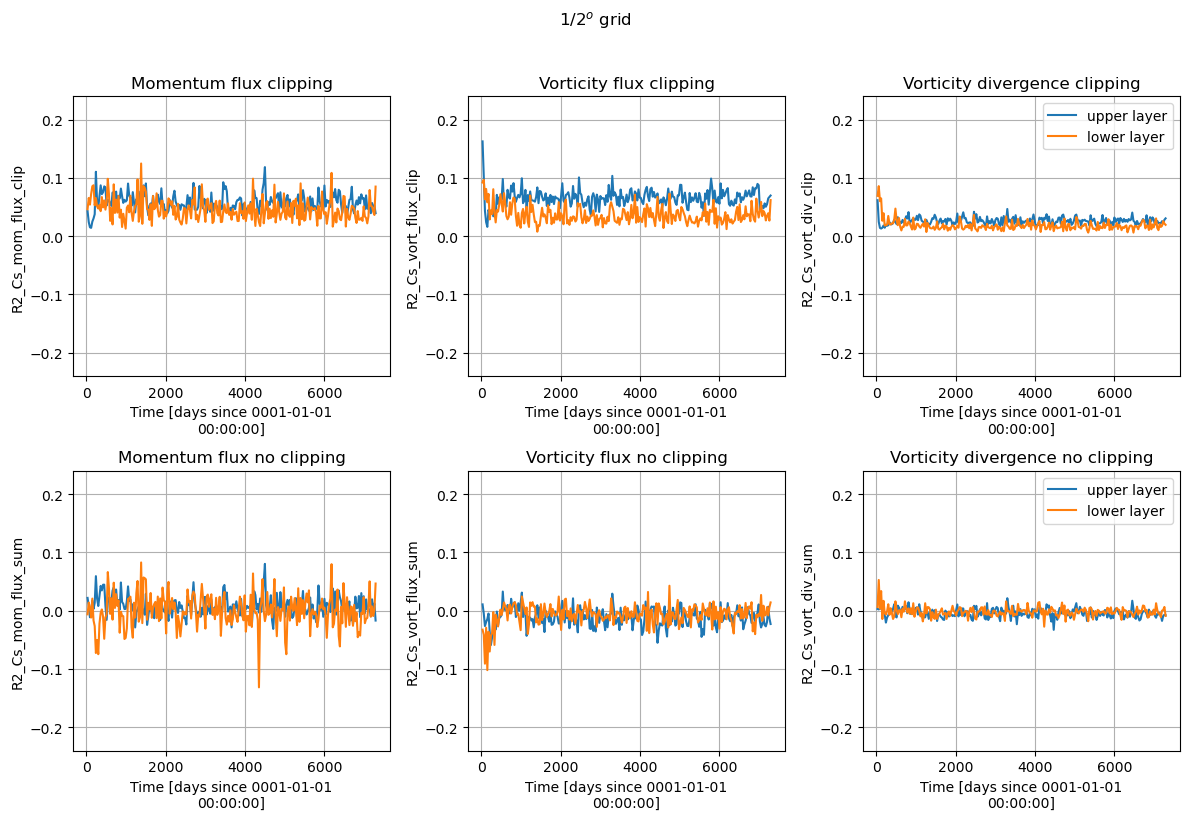

In [312]:
plot_Cs(ds_lap,'R2', ylim=0.03*8)

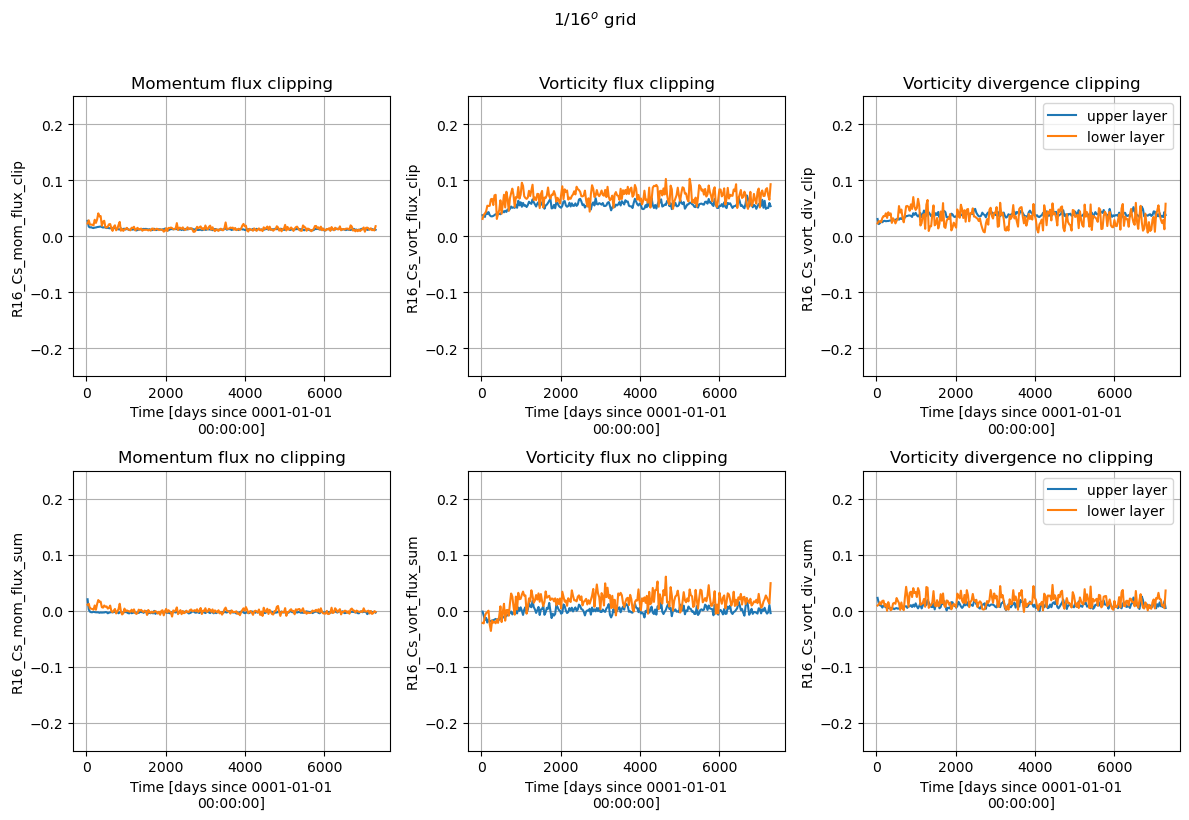

In [332]:
plot_Cs(ds_lap,'R16', ylim=0.25)
plt.savefig('a-priori/DSM-lap-kappa-sqrt2-tf-sqrt6.pdf', bbox_inches='tight')

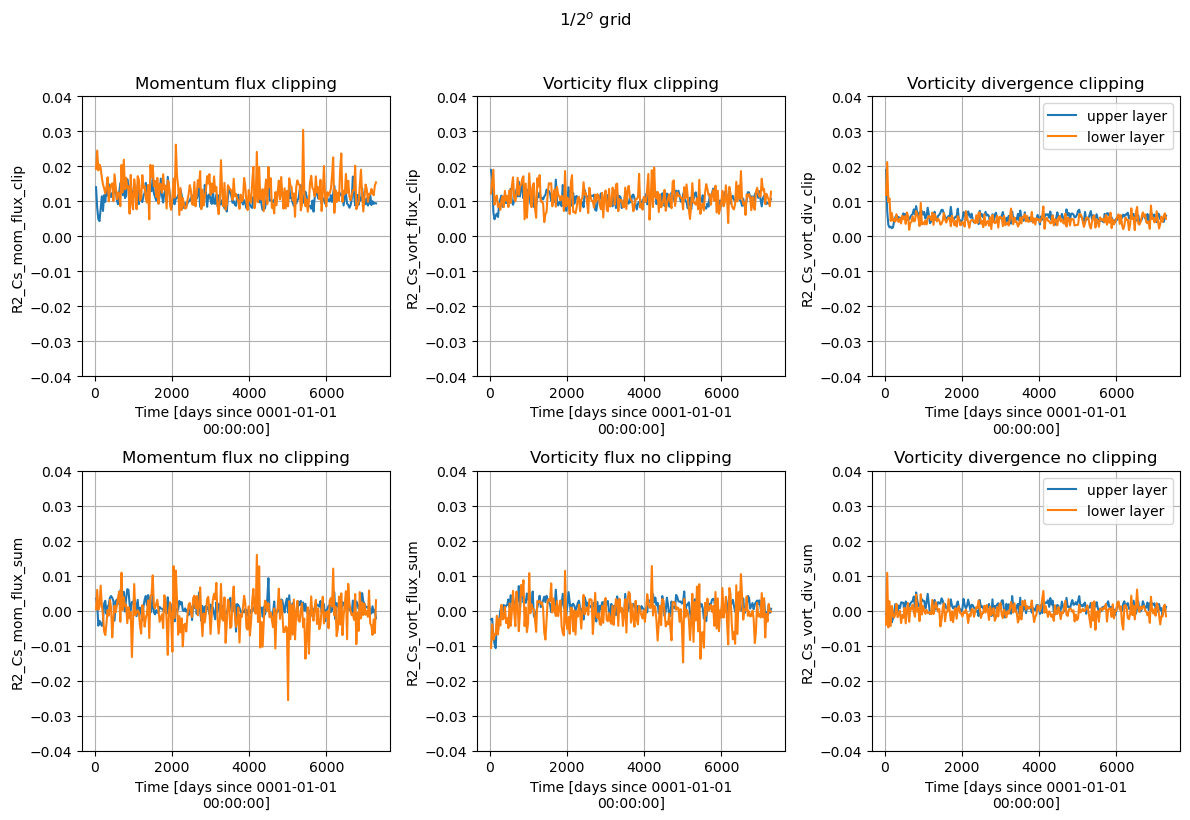

In [314]:
plot_Cs(ds,'R2', ylim=0.04)

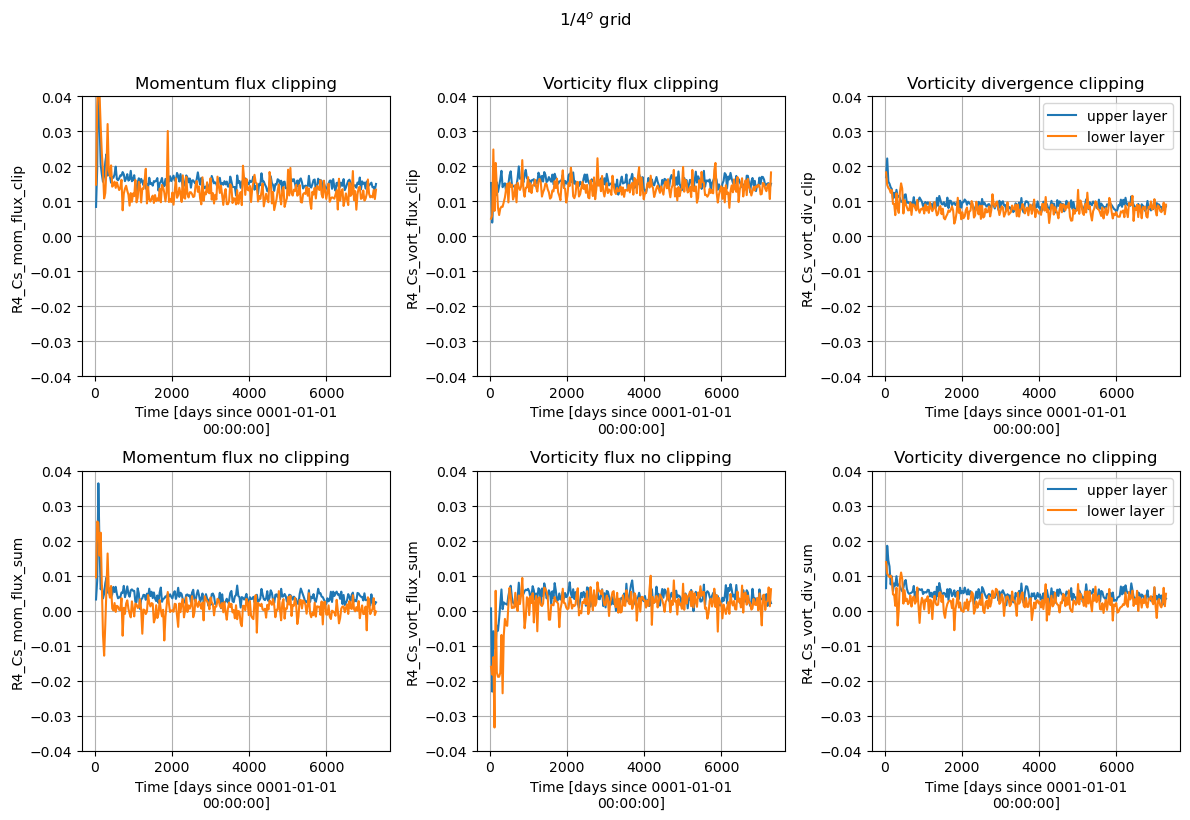

In [327]:
plot_Cs(ds,'R4', ylim=0.04)

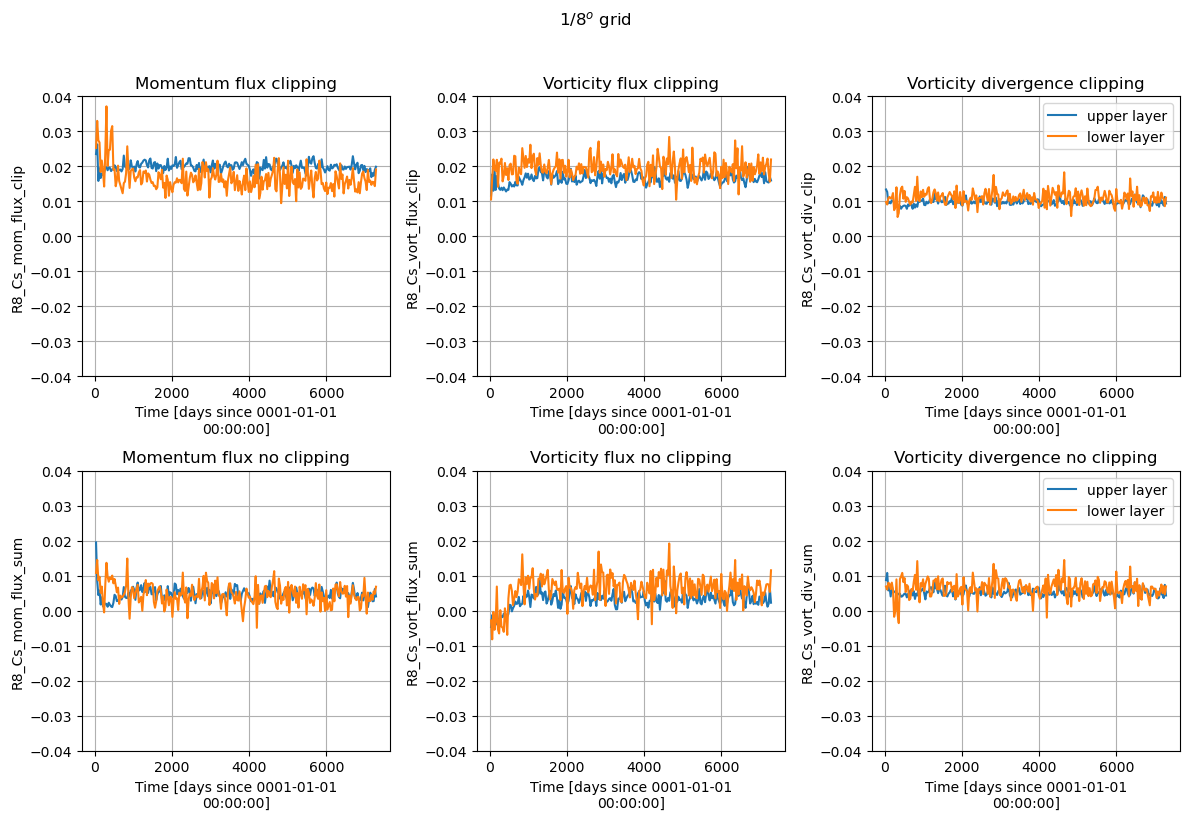

In [328]:
plot_Cs(ds,'R8', ylim=0.04)

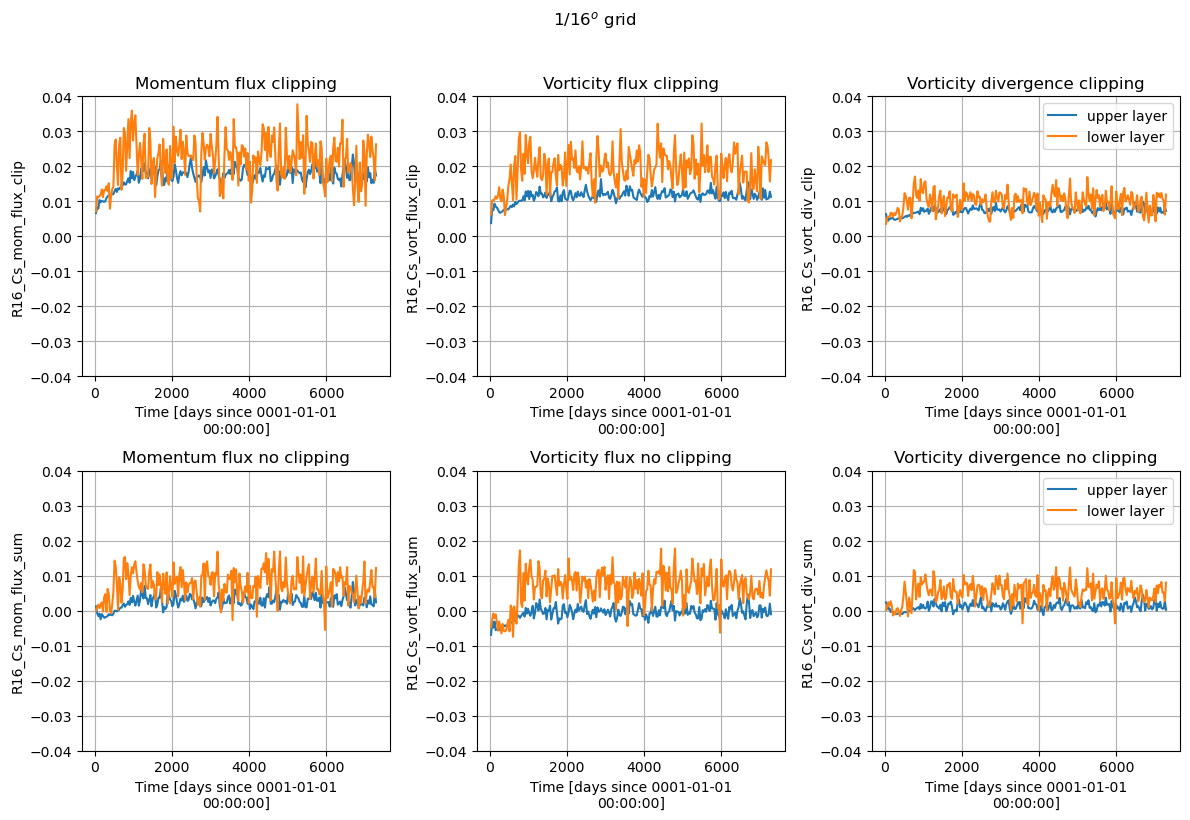

In [333]:
plot_Cs(ds,'R16', ylim=0.04)
plt.savefig('a-priori/DSM-bilap-kappa-sqrt2-tf-sqrt6.pdf', bbox_inches='tight')

# Summary over dynamic models and lap/bilap models
* **Dynamic laplacian Smagorinsky model in momentum flux formulation** in the inertial range predicts very small Smagorinsky coefficient both with clipping and without clipping. Probably it is explained by the fact that in inertial range the NGM model is accurate asymptotically, and thus strain-rate tensor is orthogonal to the momentum fluxes. Both locally and globally. Thus, both clipped and not clipped versions cannot estimate the Smagorinsky coefficient. In barotropic vorticity equation I also have seen overly small prediction of Smagorinsky coefficient in DSM, in both clipped and unclipped models.
* Our from inertial range it is impossible to predict Smagorinsky coefficient without clipping. With any model.
* Prediction in divergence of voticity fluxes is small for all cases. Probably, this feature does not correlate with subgrid forcing.
* For the biharmonic Smagorinsky model both dynamic procedures, in momentum and vorticity fluxes, can be successfully used, but only with clipping.
* As compared to the barotropic vorticity equation, the performance of the higher-order fluxes does not seem to delive obvious improvement. Probably it happens because of the complexity which results in the dominance of the Germano terms near the boundary (i.e. assumption of homogeneous turbulence in inertial range is violated).
* Momentum flux and vorticity flux formulations of biharmonic Smagorinsky models with clipping seem to be competitive and it is difficult to choose the best among two of them. It means that probably in a posteriori experiments they perform similarly.

In [316]:
prog, static = read_data('R8')
%time dyn = dyn_model(prog, static)

CPU times: user 3min 52s, sys: 13.8 s, total: 4min 6s
Wall time: 25.6 s


# LM term is concentrated near the boundary, and consequently its accuracty is debatable. That is why lower order of filtering/derivative must be preferable.

Text(0.5, 1.0, '$lm$')

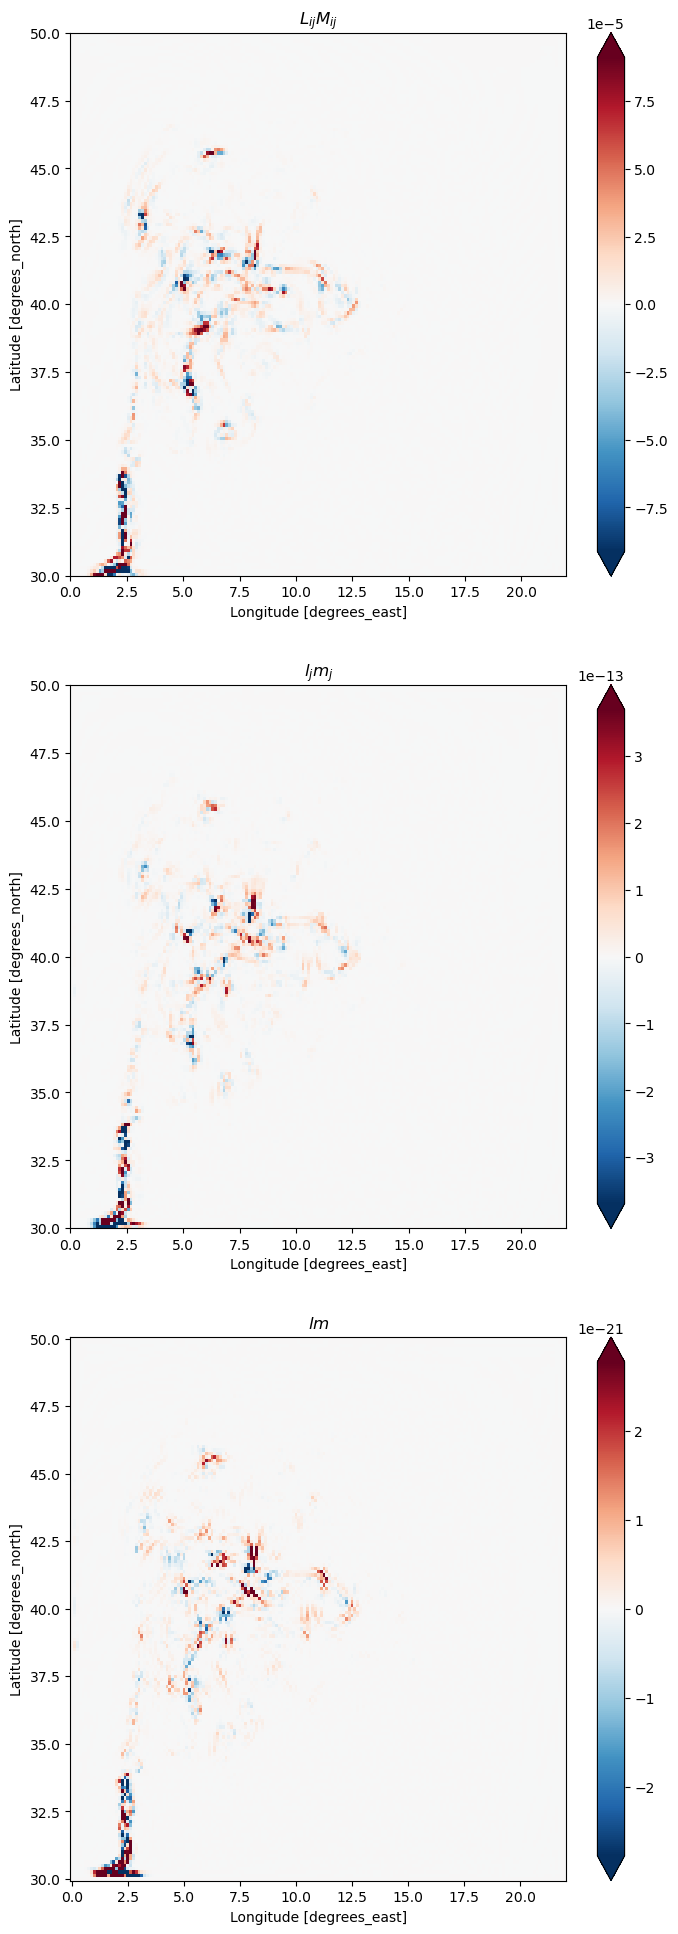

In [329]:
plt.figure(figsize=(8,24))
plt.subplot(3,1,1)
f = dyn['lm_mom_flux'].isel(Time=-1,zl=0)
f.plot(vmax=5*f.std().data)
plt.title('$L_{ij}M_{ij}$')

plt.subplot(3,1,2)
f = dyn['lm_vort_flux'].isel(Time=-1,zl=0)
f.plot(vmax=5*f.std().data)
plt.title('$l_jm_j$')

plt.subplot(3,1,3)
f = dyn['lm_vort_div'].isel(Time=-1,zl=0)
f.plot(vmax=5*f.std().data)
plt.title('$lm$')

In [5]:
ds = xr.Dataset()
for RR in ['R2', 'R4', 'R8', 'R16']:
    prog, static = read_data(RR)
    %time dyn = dyn_model(prog, static, tf_width=np.sqrt(3), tf_iter=2)
    for key in ['Cs_vort_flux_sum', 'Cs_vort_flux_clip', 'Cs_vort_div_sum', 'Cs_vort_div_clip', 'Cs_mom_flux_sum', 'Cs_mom_flux_clip']:
        ds[f'{RR}_{key}'] = dyn[key]

CPU times: user 35.4 s, sys: 1.85 s, total: 37.3 s
Wall time: 20.3 s
CPU times: user 1min 25s, sys: 10.1 s, total: 1min 35s
Wall time: 23.9 s
CPU times: user 5min 29s, sys: 35.5 s, total: 6min 5s
Wall time: 40.7 s
CPU times: user 25min 18s, sys: 13min 16s, total: 38min 34s
Wall time: 2min 28s


In [6]:
ds.to_netcdf('a-priori/bihDSM-kappa-sqrt2-tf-sqrt3-tf-iter-2.nc')

# Using test filter with width more than sqrt(6) on 3-point stencil does not increase predicted Smagorinsky coefficient

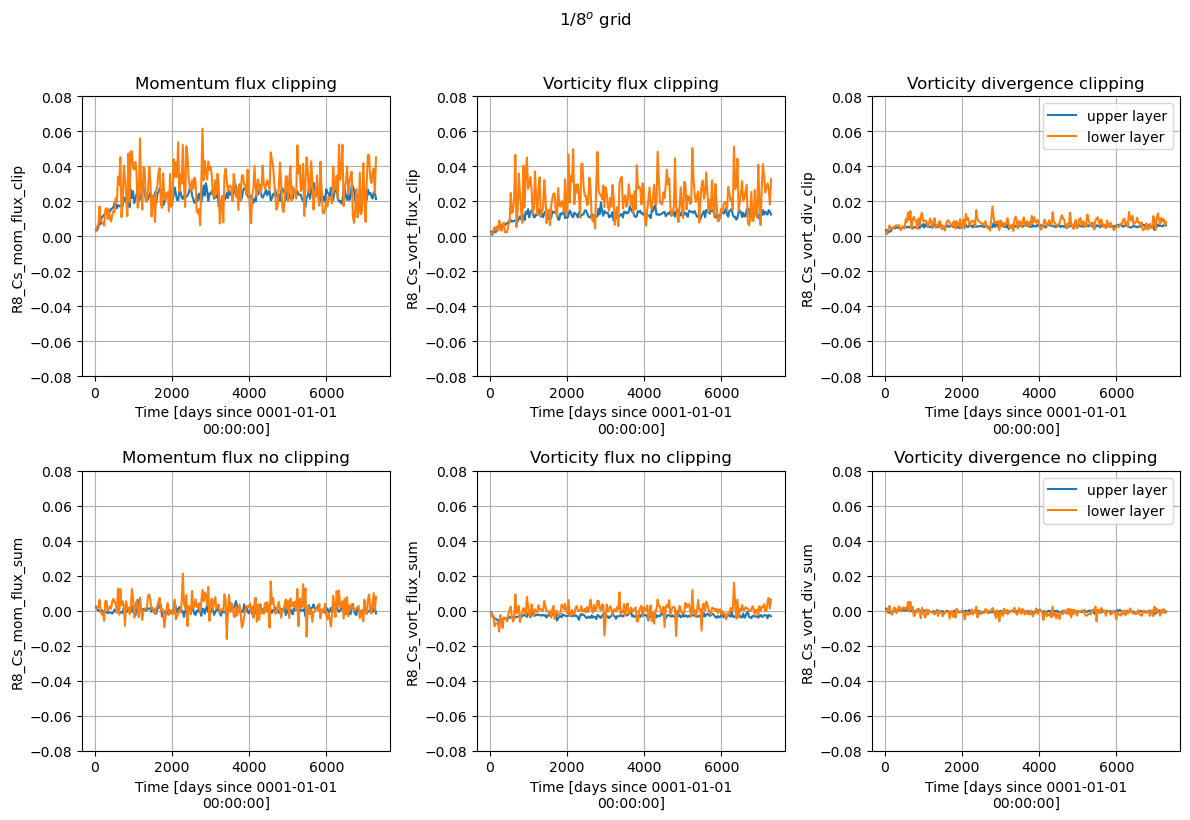

In [52]:
plot_Cs(xr.open_dataset('a-priori/bihDSM-kappa-sqrt2-tf-sqrt12.nc', decode_times=False),'R8', ylim=0.08)

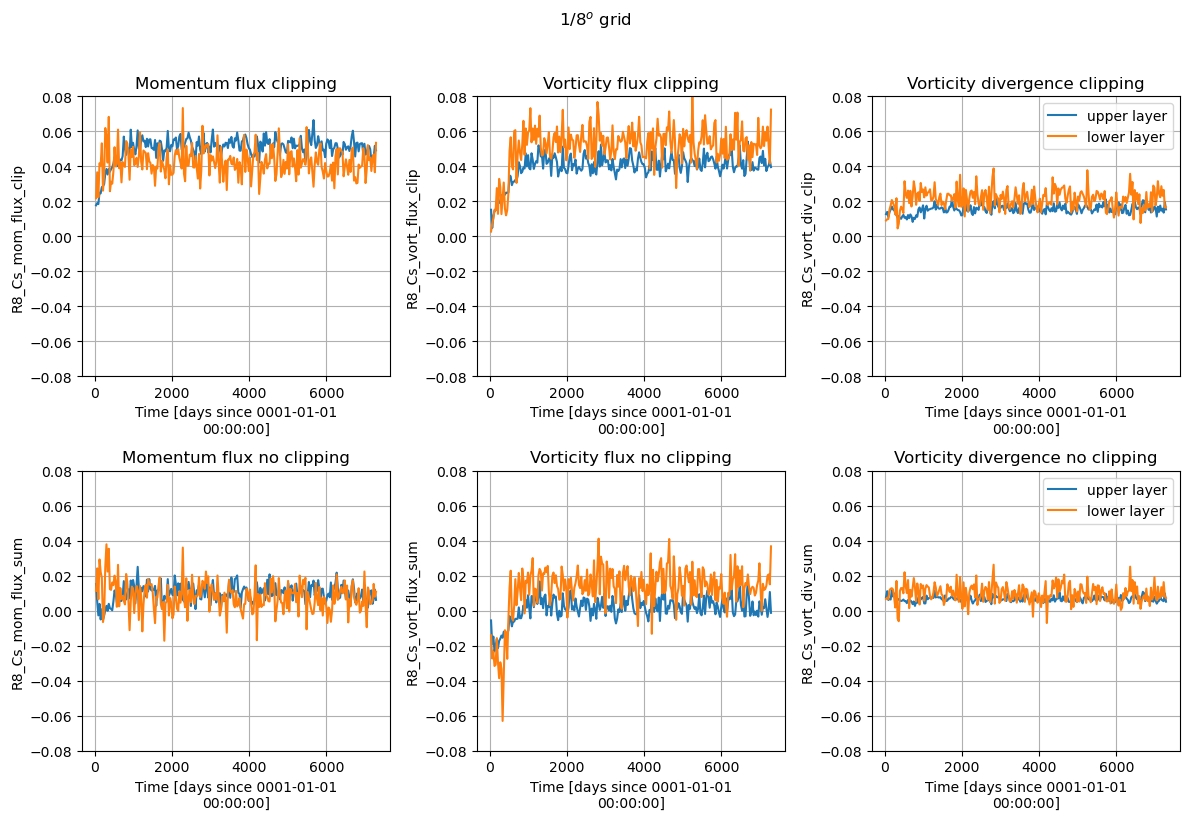

In [50]:
plot_Cs(xr.open_dataset('a-priori/bihDSM-kappa-sqrt2-tf-sqrt6-tf-iter-2.nc', decode_times=False),'R8', ylim=0.08)

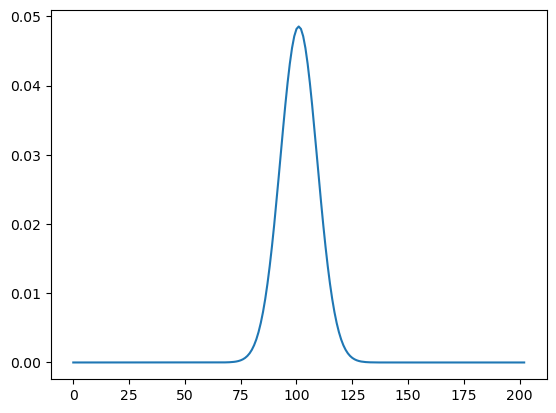

In [48]:
x = np.array([1/3,1/3,1/3])
y = x
for i in range(100):
    y = np.convolve(y,x)
plt.plot(y)

In [16]:
ds = xr.Dataset()
for RR in ['R2', 'R4', 'R8', 'R16']:
    prog, static = read_data(RR)
    %time dyn = dyn_model_Chinese(prog, static, tf_width=np.sqrt(6), tf_iter=1)
    for key in ['Cs_vort_flux_sum', 'Cs_vort_flux_clip', 'Cs_vort_div_sum', 'Cs_vort_div_clip', 'Cs_mom_flux_sum', 'Cs_mom_flux_clip']:
        ds[f'{RR}_{key}'] = dyn[key]

CPU times: user 15.4 s, sys: 1.05 s, total: 16.4 s
Wall time: 8.24 s
CPU times: user 42.4 s, sys: 2.27 s, total: 44.6 s
Wall time: 9.81 s
CPU times: user 2min 48s, sys: 12 s, total: 3min
Wall time: 18 s
CPU times: user 11min 45s, sys: 4min 45s, total: 16min 31s
Wall time: 1min 4s


In [32]:
ds.to_netcdf('a-priori/bihDSM-Chinese-tf-sqrt6.nc')

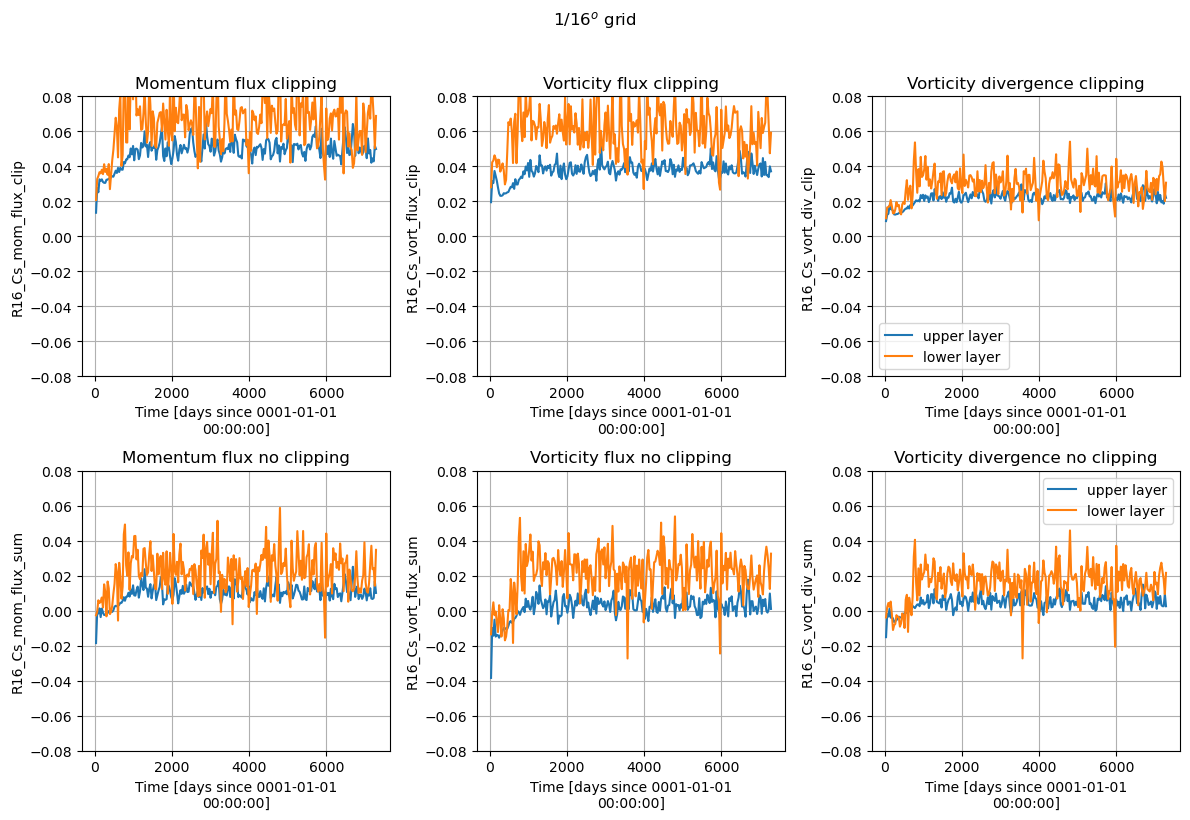

In [54]:
plot_Cs(xr.open_dataset('a-priori/bihDSM-Chinese-tf-sqrt6.nc', decode_times=False),'R16', ylim=0.08)

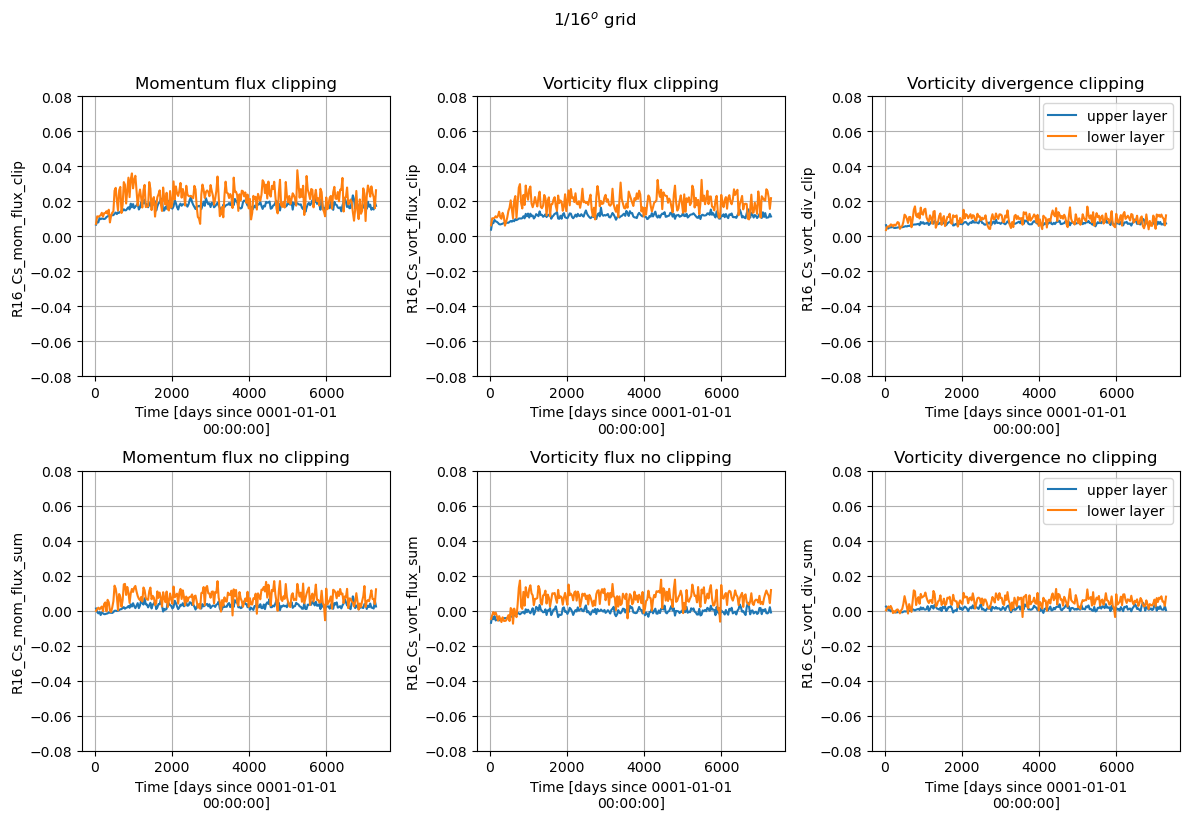

In [53]:
plot_Cs(xr.open_dataset('a-priori/bihDSM-kappa-sqrt2-tf-sqrt6.nc', decode_times=False),'R16', ylim=0.08)

# Full comparison of different options

In [3]:
def plot_boxes_clipping(file = 'a-priori/bihDSM-kappa-sqrt2-tf-sqrt6.nc', ylim=0.06):
    plt.figure(figsize=(12,8))
    ds = xr.open_dataset(file,decode_times=False)
    plt.subplot(2,2,1)
    zl=0
    plt.boxplot([ds[f'{RR}_Cs_mom_flux_clip'].isel(zl=zl) for RR in ['R2', 'R4', 'R8', 'R16']])
    plt.xticks([1,2,3,4],['$1/2^o$', '$1/4^o$', '$1/8^o$', '$1/16^o$'])
    plt.ylim([-0.02,ylim])
    plt.axhline(y=0,color='k')
    plt.grid()
    plt.ylabel('Upper Layer $C_S$ of $\\nabla^4$', fontsize=15)
    plt.title('Momentum fluxes \n with clipping: $\\dfrac{\\langle (L_{ij} M_{ij})_+ \\rangle}{\\langle M_{ij} M_{ij} \\rangle}$', fontsize=15)

    plt.subplot(2,2,2)
    zl=0
    plt.boxplot([ds[f'{RR}_Cs_vort_flux_clip'].isel(zl=zl) for RR in ['R2', 'R4', 'R8', 'R16']])
    plt.xticks([1,2,3,4],['$1/2^o$', '$1/4^o$', '$1/8^o$', '$1/16^o$'])
    plt.ylim([-0.02,ylim])
    plt.axhline(y=0,color='k')
    plt.grid()
    plt.title('Vorticity fluxes \n with clipping: $\\dfrac{\\langle (l_{j} m_{j})_+ \\rangle}{\\langle m_{j} m_{j} \\rangle}$', fontsize=15)
    
    plt.subplot(2,2,3)
    zl=1
    plt.boxplot([ds[f'{RR}_Cs_mom_flux_clip'].isel(zl=zl) for RR in ['R2', 'R4', 'R8', 'R16']])
    plt.xticks([1,2,3,4],['$1/2^o$', '$1/4^o$', '$1/8^o$', '$1/16^o$'])
    plt.ylim([-0.02,ylim])
    plt.axhline(y=0,color='k')
    plt.grid()
    plt.ylabel('Lower Layer $C_S$ of $\\nabla^4$', fontsize=15)

    plt.subplot(2,2,4)
    zl=1
    plt.boxplot([ds[f'{RR}_Cs_vort_flux_clip'].isel(zl=zl) for RR in ['R2', 'R4', 'R8', 'R16']])
    plt.xticks([1,2,3,4],['$1/2^o$', '$1/4^o$', '$1/8^o$', '$1/16^o$'])
    plt.ylim([-0.02,ylim])
    plt.axhline(y=0,color='k')
    plt.grid()
    #plt.title('Vorticity fluxes \n with clipping: $\\dfrac{\\langle (l_{j} m_{j})_+ \\rangle}{\\langle m_{j} m_{j} \\rangle}$', fontsize=15)

In [4]:
def plot_boxes_noclipping(file = 'a-priori/bihDSM-kappa-sqrt2-tf-sqrt6.nc'):
    plt.figure(figsize=(12,8))
    ds = xr.open_dataset(file,decode_times=False)
    plt.subplot(2,2,1)
    zl=0
    plt.boxplot([ds[f'{RR}_Cs_mom_flux_sum'].isel(zl=zl) for RR in ['R2', 'R4', 'R8', 'R16']])
    plt.xticks([1,2,3,4],['$1/2^o$', '$1/4^o$', '$1/8^o$', '$1/16^o$'])
    plt.ylim([-0.02,0.06])
    plt.axhline(y=0,color='k')
    plt.grid()
    plt.ylabel('Upper Layer $C_S$ of $\\nabla^4$', fontsize=15)
    plt.title('Momentum fluxes \n without clipping: $\\dfrac{\\langle L_{ij} M_{ij} \\rangle}{\\langle M_{ij} M_{ij} \\rangle}$', fontsize=15)

    plt.subplot(2,2,2)
    zl=0
    plt.boxplot([ds[f'{RR}_Cs_vort_flux_sum'].isel(zl=zl) for RR in ['R2', 'R4', 'R8', 'R16']])
    plt.xticks([1,2,3,4],['$1/2^o$', '$1/4^o$', '$1/8^o$', '$1/16^o$'])
    plt.ylim([-0.02,0.06])
    plt.axhline(y=0,color='k')
    plt.grid()
    plt.title('Vorticity fluxes \n without clipping: $\\dfrac{\\langle l_{j} m_{j} \\rangle}{\\langle m_{j} m_{j} \\rangle}$', fontsize=15)
    
    plt.subplot(2,2,3)
    zl=1
    plt.boxplot([ds[f'{RR}_Cs_mom_flux_sum'].isel(zl=zl) for RR in ['R2', 'R4', 'R8', 'R16']])
    plt.xticks([1,2,3,4],['$1/2^o$', '$1/4^o$', '$1/8^o$', '$1/16^o$'])
    plt.ylim([-0.02,0.06])
    plt.axhline(y=0,color='k')
    plt.grid()
    plt.ylabel('Lower Layer $C_S$ of $\\nabla^4$', fontsize=15)

    plt.subplot(2,2,4)
    zl=1
    plt.boxplot([ds[f'{RR}_Cs_vort_flux_sum'].isel(zl=zl) for RR in ['R2', 'R4', 'R8', 'R16']])
    plt.xticks([1,2,3,4],['$1/2^o$', '$1/4^o$', '$1/8^o$', '$1/16^o$'])
    plt.ylim([-0.02,0.06])
    plt.axhline(y=0,color='k')
    plt.grid()
    #plt.title('Vorticity fluxes \n with clipping: $\\dfrac{\\langle (l_{j} m_{j})_+ \\rangle}{\\langle m_{j} m_{j} \\rangle}$', fontsize=15)

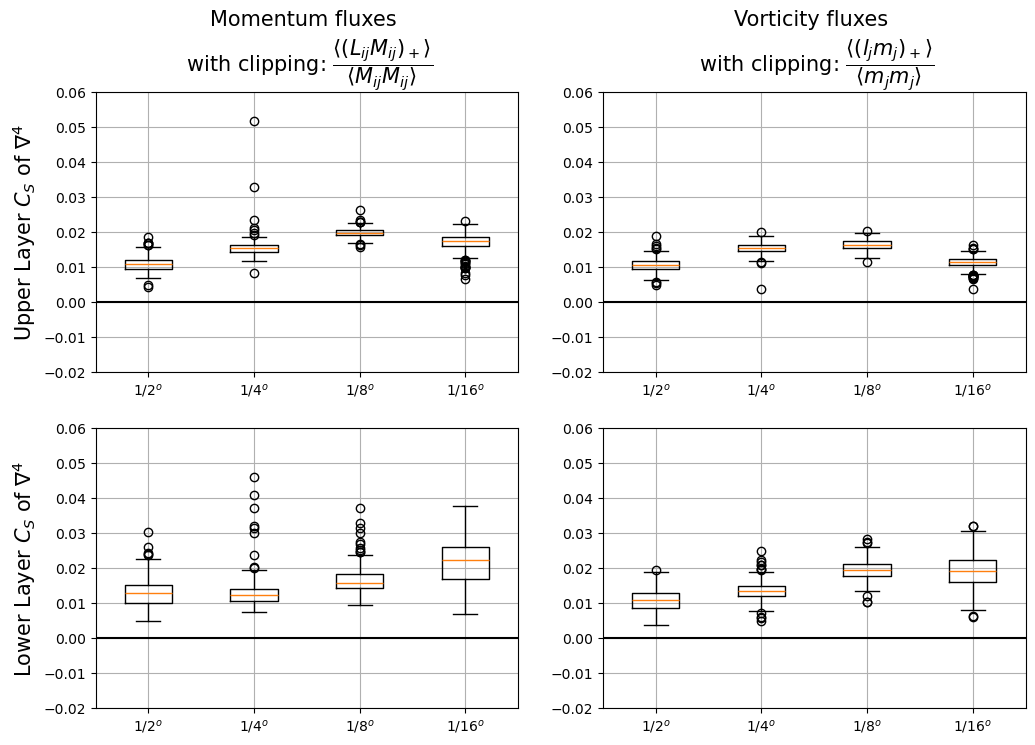

In [119]:
plot_boxes_clipping('a-priori/bihDSM-kappa-sqrt2-tf-sqrt6.nc')
plt.savefig('a-priori/bihDSM-kappa-sqrt2-tf-sqrt6-clipping.pdf')

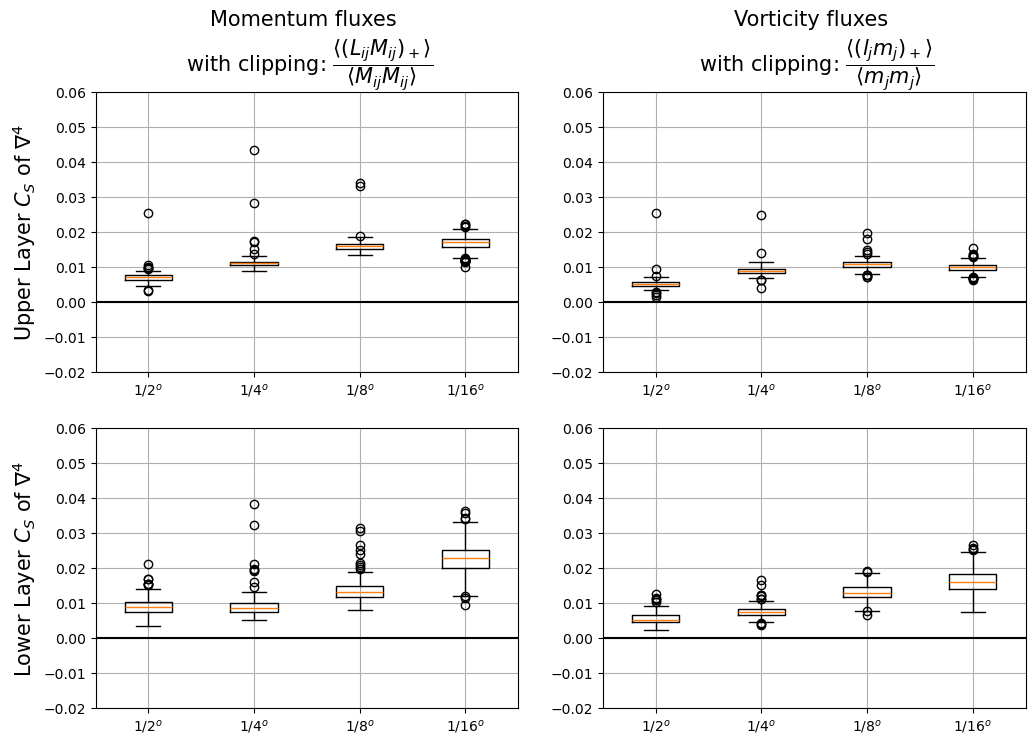

In [126]:
plot_boxes_clipping('a-priori/bihDSM-kappa-sqrt2-tf-sqrt3-tf-iter-2.nc')
plt.savefig('a-priori/bihDSM-kappa-sqrt2-tf-sqrt3-tf-iter-2-clipping.pdf')

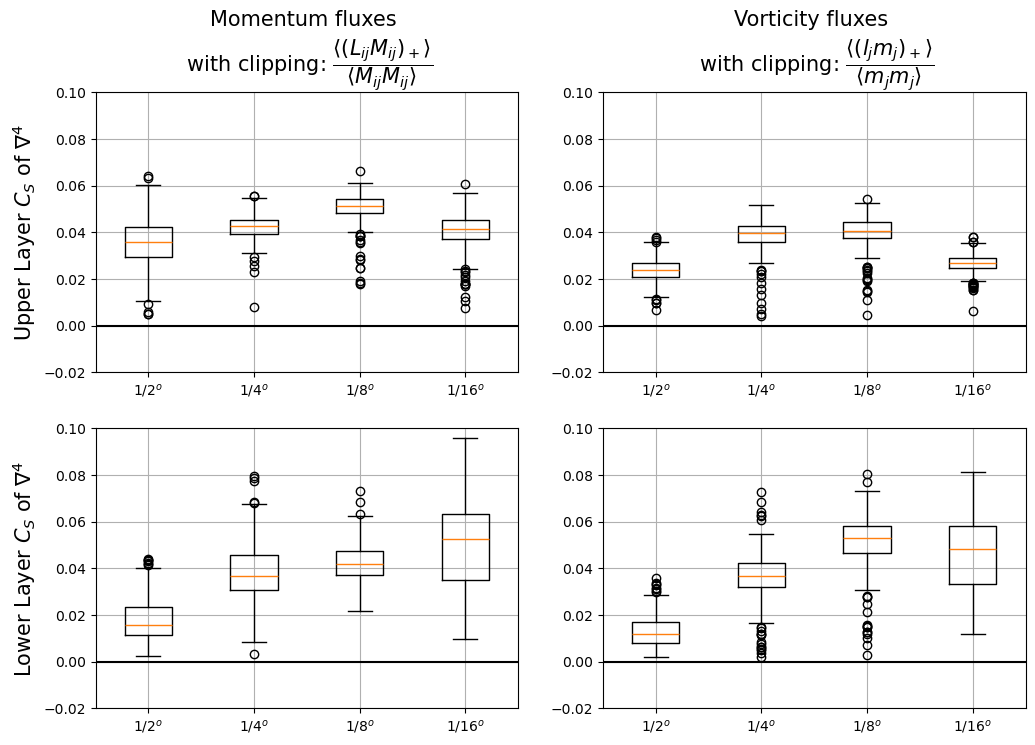

In [129]:
plot_boxes_clipping('a-priori/bihDSM-kappa-sqrt2-tf-sqrt6-tf-iter-2.nc', ylim=0.1)
plt.savefig('a-priori/bihDSM-kappa-sqrt2-tf-sqrt6-tf-iter-2-clipping.pdf')

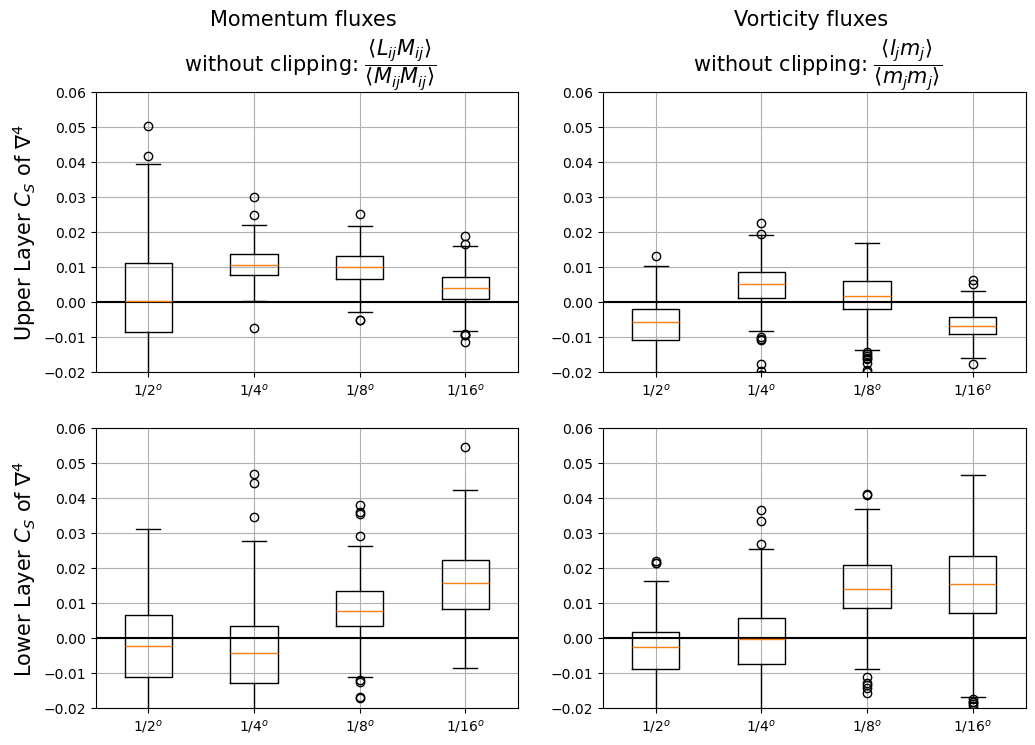

In [8]:
plot_boxes_noclipping('a-priori/bihDSM-kappa-sqrt2-tf-sqrt6-tf-iter-2.nc')
plt.savefig('a-priori/bihDSM-kappa-sqrt2-tf-sqrt6-tf-iter-2-noclipping.pdf')

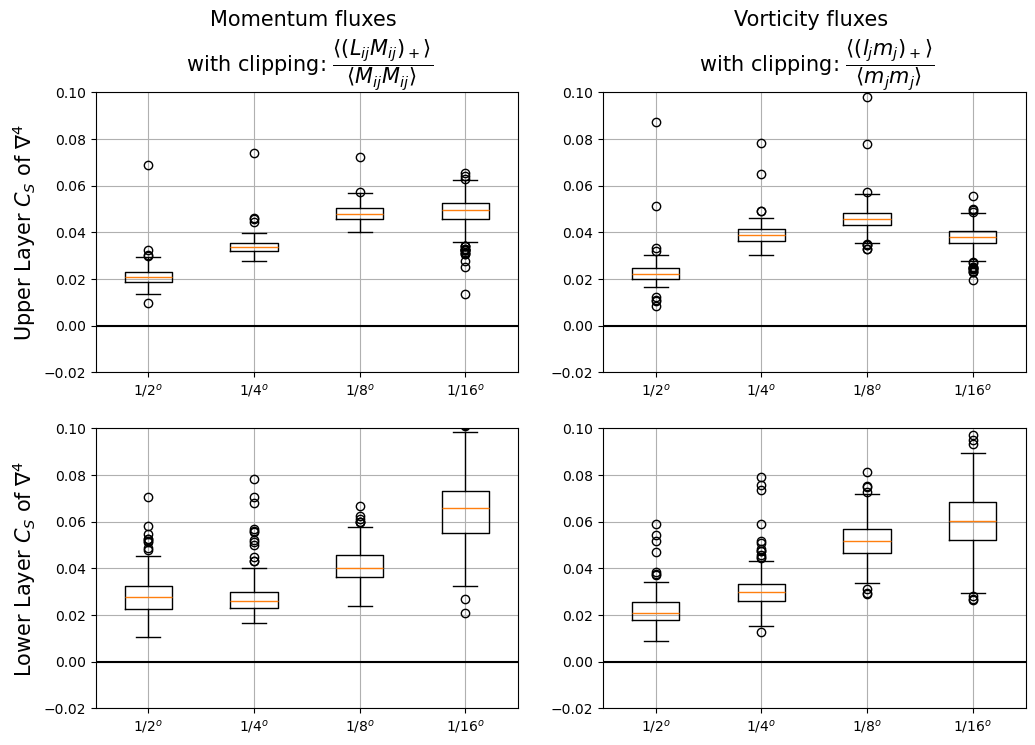

In [130]:
plot_boxes_clipping('a-priori/bihDSM-Chinese-tf-sqrt6.nc', ylim=0.1)
plt.savefig('a-priori/bihDSM-Chinese-sqrt6-clipping.pdf')

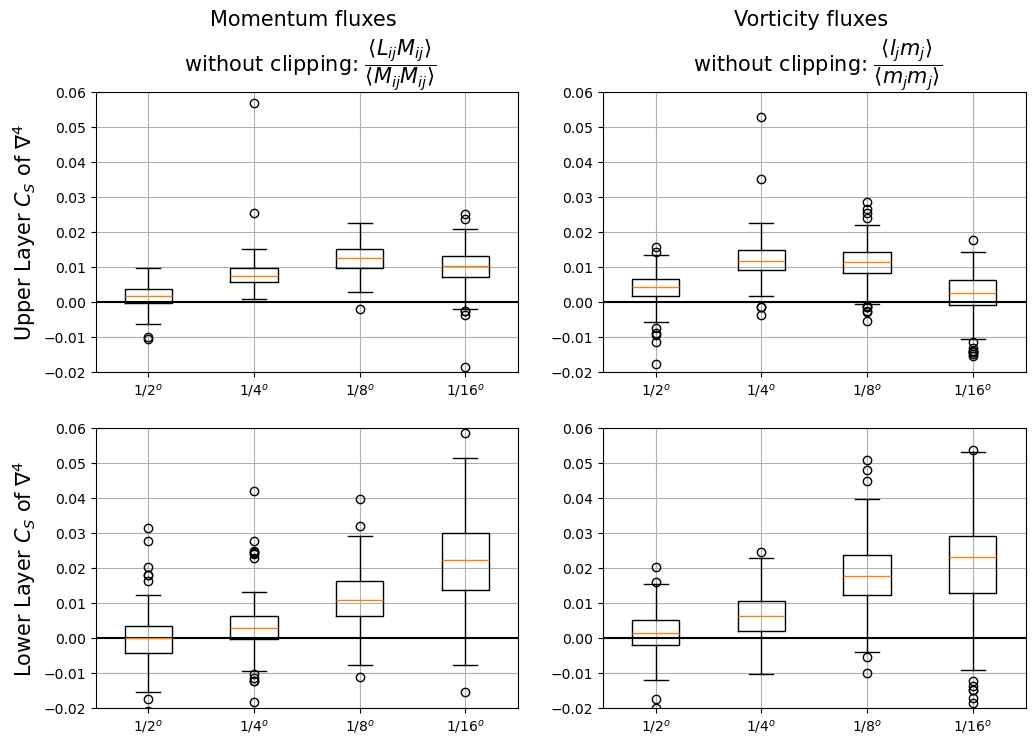

In [6]:
plot_boxes_noclipping('a-priori/bihDSM-Chinese-tf-sqrt6.nc')
plt.savefig('a-priori/bihDSM-Chinese-sqrt6-noclipping.pdf')

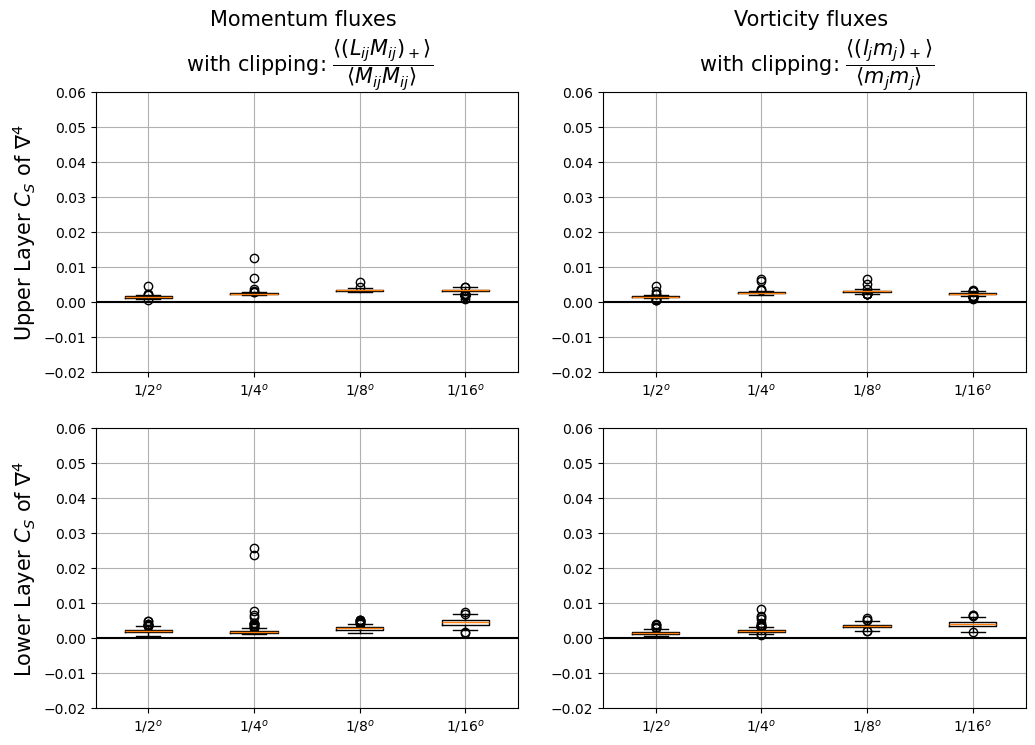

In [120]:
plot_boxes_clipping('a-priori/bihDSM-kappa-2-tf-sqrt6.nc')
plt.savefig('a-priori/bihDSM-kappa-2-tf-sqrt6-clipping.pdf')

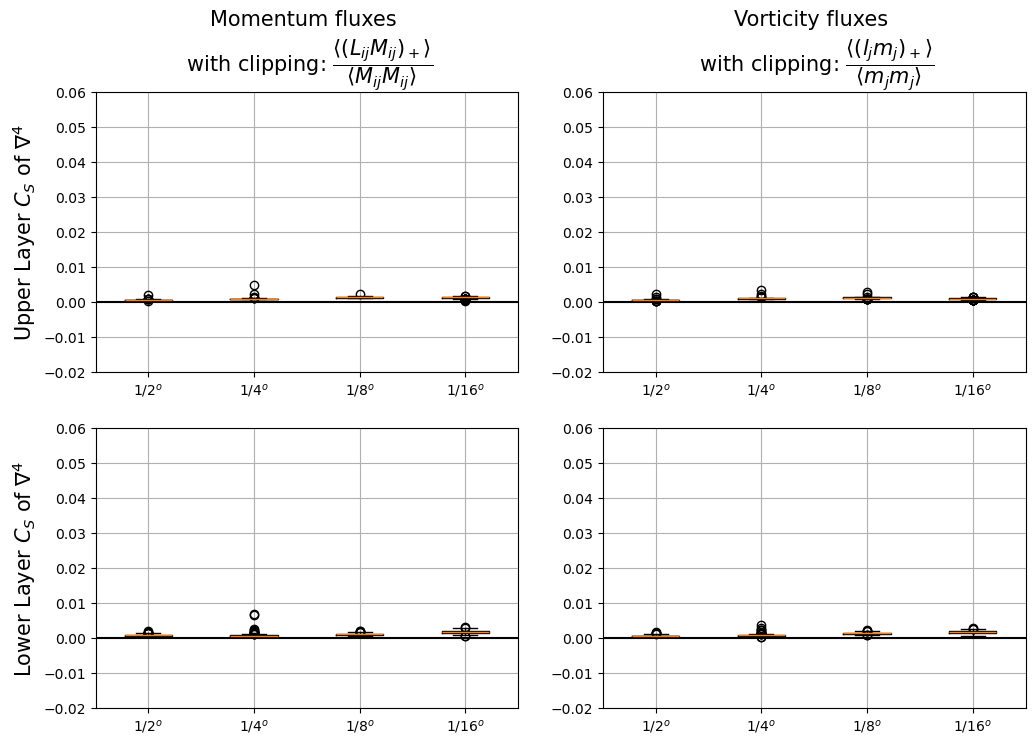

In [121]:
plot_boxes_clipping('a-priori/bihDSM-kappa-sqrt6-tf-sqrt6.nc')
plt.savefig('a-priori/bihDSM-kappa-sqrt6-tf-sqrt6-clipping.pdf')

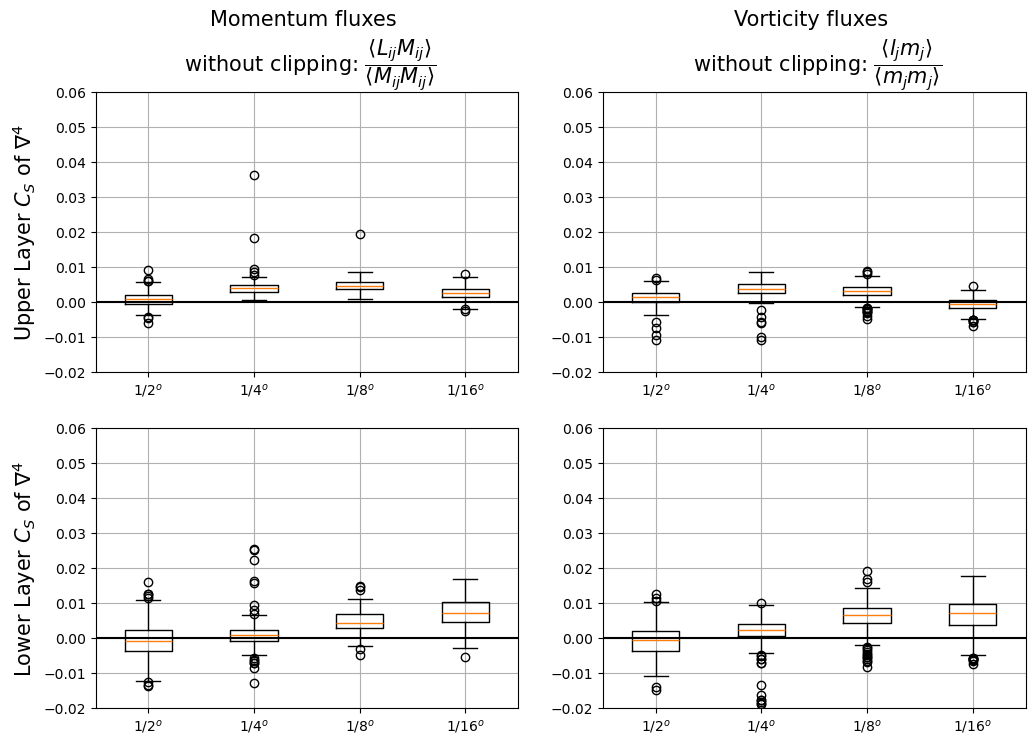

In [118]:
plot_boxes_noclipping()
plt.savefig('a-priori/bihDSM-kappa-sqrt2-tf-sqrt6-no-clipping.pdf')

In [44]:
filename = '/home/ctrsp-2024/pp2681/experiments/generalization/zelong-False-ssm-False-reduce-0/R2/mom.sub'
with open(filename,'w') as fid:
    pass